In [38]:
# packages
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/home/el2358/.conda/envs/geoclim/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# some configurations on the default figure output
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.dpi'] = 120

# Part 1: Data Preprocessing

## Initial configuration

Data files, training vs. testing years, etc.

In [3]:
# ========== USER CONFIG ==========

data_dir = "/scratch/gpfs/GVECCHI/el2358/ACE2_1000/daily/sst"   # directory with daily_sst_YYYY.nc files
file_template = "daily_sst_{year}.nc"
years_all = np.arange(1940, 2023)   # 1940..2022 inclusive
train_years = np.arange(1940, 2011) # 1940..2010
test_years = np.arange(2011, 2023)  # 2011..2022

sst_var = "surface_temperature"   # netCDF variable name
plot_output_dir = "./outputs_eof_ridge"
os.makedirs(plot_output_dir, exist_ok=True)

# dates for predictor and target windows relative to a "season year"
# For season based on your description:
# Aug-Nov of year Y -> predict Dec of year Y, Jan-Feb of year Y+1
# We'll represent a season by its starting year Y.
import datetime

# helper to build date ranges for a given season start year y
def predictor_dates_for_year(y):
    # Aug 1 -> Nov 30 of year y
    start = pd.Timestamp(year=y, month=8, day=1)
    end   = pd.Timestamp(year=y, month=11, day=30)
    return pd.date_range(start, end, freq='D')

def target_dates_for_year(y):
    # Dec 1 of year y -> Feb 28 of year y+1 (we remove Feb 29 globally)
    start = pd.Timestamp(year=y, month=12, day=1)
    end   = pd.Timestamp(year=y+1, month=2, day=28)  # exclude leap-day
    return pd.date_range(start, end, freq='D')

## Loading data

Opening all the SST files and creating one xarray of daily SSTs across the full available record of ACE2 model forcing data

In [4]:
# ========== Load datasets and concatenate into one xarray DataArray ==========
def open_all_years(years):
    files = []
    for y in years:
        fname = os.path.join(data_dir, file_template.format(year=int(y)))
        if not os.path.exists(fname):
            raise FileNotFoundError(f"Missing file: {fname}")
        files.append(fname)
    ds = xr.open_mfdataset(
    files,
    combine='nested',
    concat_dim='time',
    compat='override',
    coords='minimal')
    # ensure sst var exists
    if sst_var not in ds:
        raise KeyError(f"{sst_var} not in dataset. Available: {list(ds.data_vars)}")
    sst = ds[sst_var]
    # convert times to pandas DatetimeIndex if needed
    if not np.issubdtype(sst.indexes['time'].dtype, np.datetime64):
        sst['time'] = xr.conventions.times.decode_cf_datetime(sst['time'], ds['time'].attrs.get('units', None))
    return sst

print("Loading data...")
sst_all = open_all_years(years_all)  # dims: time, lat, lon

# remove leap days globally (Feb 29)
time = pd.DatetimeIndex(sst_all['time'].values)
leap_mask = ~((time.month == 2) & (time.day == 29))
sst_all = sst_all.sel(time=leap_mask)
time = pd.DatetimeIndex(sst_all['time'].values)  # update

# check coords
lat = sst_all['latitude'].values
lon = sst_all['longitude'].values
nlat, nlon = len(lat), len(lon)
N = nlat * nlon

Loading data...


In [5]:
sst_all

<xarray.DataArray 'surface_temperature' (time: 30295, latitude: 180,
                                         longitude: 360)> Size: 8GB
dask.array<getitem, shape=(30295, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 1kB -89.24 -88.25 -87.25 ... 87.25 88.25 89.24
  * longitude  (longitude) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * time       (time) datetime64[ns] 242kB 1940-01-01 1940-01-02 ... 2022-12-31
Attributes: (12/30)
    GRIB_N:                                   90
    GRIB_NV:                                  276
    GRIB_Ni:                                  360
    GRIB_Nj:                                  180
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           skt
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    long_name:                                Skin temperature
    standard_name:                            unknown
    units:                                    K

## Data preprocessing

1. Remove Feb 29 (ignoring leap years)
2. Select training vs. testing period
3. Compute the daily climatology using the training data
4. Compute anomalies from the climatolgy with the training data and testing data

In [6]:
print("\n==================== STEP 1: Remove leap days ====================")

# Remove Feb 29
mask_no_leap = ~((sst_all.time.dt.month == 2) & (sst_all.time.dt.day == 29))
sst_no_leap = sst_all.sel(time=mask_no_leap)

print("Original length:", sst_all.time.size)
print("After removing Feb 29:", sst_no_leap.time.size)

# Check min/max dates
print("No-leap time range:", sst_no_leap.time.min().values, "to", sst_no_leap.time.max().values)

# Check if any Feb 29 remains
remaining_feb29 = sst_no_leap.time[(sst_no_leap.time.dt.month == 2) & (sst_no_leap.time.dt.day == 29)]
print("Remaining Feb 29 entries:", remaining_feb29.values)


print("\n==================== STEP 2: Select training years ====================")

sst_train = sst_no_leap.sel(time=slice("1940-01-01", "2010-12-31"))
sst_test = sst_no_leap.sel(time=slice("2011-01-01", "2022-12-31"))

print("Training years time range:", sst_train.time.min().values, "to", sst_train.time.max().values)
print("Training length:", sst_train.time.size)

print("Testing years time range:", sst_test.time.min().values, "to", sst_test.time.max().values)
print("Training length:", sst_test.time.size)

# Check if any Feb 29 remains **inside training years**
train_feb29 = sst_train.time[(sst_train.time.dt.month == 2) & (sst_train.time.dt.day == 29)]
print("Feb 29 inside TRAINING:", train_feb29.values)


print("\n==================== STEP 3: Day-of-year diagnostics ====================")

# What are the unique DOYs in the training set?
doys_train = np.unique(sst_train.time.dt.dayofyear.values)
print("Unique dayofyear values in training:", doys_train[:20], "...", doys_train[-20:])
print("Count unique dayofyear:", len(doys_train))

# There should be exactly 365 DOYs. If it's 366, we have a problem.


print("\n==================== STEP 4: Compute climatology USING TRAINING DATA ONLY ====================")

clim = sst_train.groupby("time.dayofyear").mean("time")

print("Climatology dims:", clim.dims)
print("Climatology size dayofyear:", clim.sizes.get("dayofyear"))

# Print the actual DOY list in climatology
print("Climatology DOYs (first 20):", list(clim.dayofyear.values[:20]))
print("Climatology DOYs (last 20):", list(clim.dayofyear.values[-20:]))


print("\n==================== STEP 5: Compute anomalies for full record ====================")

sst_anom_full = sst_no_leap.groupby("time.dayofyear") - clim

print("sst_anom_full dims:", sst_anom_full.dims)
print("sst_anom_full length:", sst_anom_full.time.size)
print("sst_anom_full range:", sst_anom_full.time.min().values, "to", sst_anom_full.time.max().values)

# Check if any Feb 29 reappeared
anom_feb29 = sst_anom_full.time[(sst_anom_full.time.dt.month == 2) & (sst_anom_full.time.dt.day == 29)]
print("Any Feb 29 in anomalies:", anom_feb29.values)


print("\n==================== STEP 6 Training-only and testing-only anomalies ====================")

sst_anom_train = sst_train.groupby("time.dayofyear") - clim
sst_anom_test = sst_test.groupby("time.dayofyear") - clim

print("sst_anom_train dims:", sst_anom_train.dims)
print("sst_anom_train len:", sst_anom_train.time.size)
print("sst_anom_train range:", sst_anom_train.time.min().values, "to", sst_anom_train.time.max().values)

print("sst_anom_test dims:", sst_anom_test.dims)
print("sst_anom_test len:", sst_anom_test.time.size)
print("sst_anom_test range:", sst_anom_test.time.min().values, "to", sst_anom_test.time.max().values)




==================== STEP 1: Remove leap days ====================
Original length: 30295
After removing Feb 29: 30295
No-leap time range: 1940-01-01T00:00:00.000000000 to 2022-12-31T00:00:00.000000000
Remaining Feb 29 entries: []

==================== STEP 2: Select training years ====================
Training years time range: 1940-01-01T00:00:00.000000000 to 2010-12-31T00:00:00.000000000
Training length: 25915
Testing years time range: 2011-01-01T00:00:00.000000000 to 2022-12-31T00:00:00.000000000
Training length: 4380
Feb 29 inside TRAINING: []

==================== STEP 3: Day-of-year diagnostics ====================
Unique dayofyear values in training: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] ... [347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364
 365 366]
Count unique dayofyear: 366

==================== STEP 4: Compute climatology USING TRAINING DATA ONLY ====================
Climatology dims: ('dayofyear', 'latitude', 'longitude')
Cl

## More data preprocessing (specifically for EOFs)

1. Apply an ocean mask to ignore land
2. Flatten the SST data into time x space single dimension
3. Apply a latitude weighting 


In [7]:
import numpy as np
import xarray as xr

# ============================================================
# FUNCTION: prepare_data_for_eofs
# Applies land mask + flatten + ocean index + lat weights
# Works for both training and testing datasets.
# ============================================================
def prepare_data_for_eofs(sst_anom, land_mask_path, reference_dataset):
    print("\n===================================================")
    print(" STEP 1: Load & Align Land Mask")
    print("===================================================\n")

    # ---------------------------
    # Load land mask
    # ---------------------------
    land_mask_ds = xr.open_dataset(land_mask_path)
    mask_var = "sst" if "sst" in land_mask_ds.data_vars else list(land_mask_ds.data_vars)[0]
    land_mask = land_mask_ds[mask_var]

    # Align coordinate names
    rename_map = {}
    if "lat" in land_mask.dims:
        rename_map["lat"] = "latitude"
    if "lon" in land_mask.dims:
        rename_map["lon"] = "longitude"
    if rename_map:
        print("Renaming land mask coords:", rename_map)
        land_mask = land_mask.rename(rename_map)

    # Create ocean mask (1=ocean, 0=land)
    binary_mask = xr.where(np.isfinite(land_mask), 1.0, 0.0)

    # Regrid the mask to the SST grid
    try:
        print("Interpolating mask to SST grid...")
        mask_on_grid = binary_mask.interp(
            latitude=reference_dataset.latitude,
            longitude=reference_dataset.longitude,
            method="nearest"
        )
    except:
        print("Broadcasting mask instead of interpolating...")
        mask_on_grid = binary_mask.broadcast_like(reference_dataset.isel(time=0))

    # Expand mask in time if needed
    if "time" not in mask_on_grid.dims:
        print("Expanding mask over time...")
        mask_expanded = mask_on_grid.broadcast_like(sst_anom)
    else:
        mask_expanded = mask_on_grid

    print("Mask expanded shape:", mask_expanded.shape)

    # ---------------------------
    # Apply mask to SST anomalies
    # ---------------------------
    print("\n===================================================")
    print(" STEP 2: Apply Ocean Mask")
    print("===================================================\n")

    sst_masked = sst_anom.where(mask_expanded == 1)
    print("Masked SST shape:", sst_masked.shape)

    # ---------------------------
    # Flatten spatial dims
    # ---------------------------
    print("\n===================================================")
    print(" STEP 3: Flatten SST (time × space)")
    print("===================================================\n")

    nlat = sst_anom.latitude.size
    nlon = sst_anom.longitude.size
    N = nlat * nlon

    sst_flat = sst_masked.values.reshape(sst_masked.time.size, N)
    print("Flattened SST shape:", sst_flat.shape)

    # Determine ocean points only
    ocean_idx = ~np.isnan(sst_flat[0, :])
    print("Number of ocean points:", ocean_idx.sum())
    print("Number of land points:", N - ocean_idx.sum())

    # Subset ocean points
    M_ocean = sst_flat[:, ocean_idx]
    print("Ocean-only matrix (time × ocean_pts):", M_ocean.shape)

    # ---------------------------
    # Latitude weighting
    # ---------------------------
    print("\n===================================================")
    print(" STEP 4: Apply Latitude Weighting")
    print("===================================================\n")

    lat_radians = np.deg2rad(sst_anom.latitude.values)
    weights_lat = np.sqrt(np.cos(lat_radians))  # shape (nlat,)
    weights_2d = np.repeat(weights_lat[:, None], nlon, axis=1)

    # Apply ocean mask before flattening
    weights_2d_masked = np.where(mask_expanded.isel(time=0) == 1, weights_2d, 0.0)

    weights_flat = weights_2d_masked.flatten()[ocean_idx]
    print("Weights (ocean-only) shape:", weights_flat.shape)

    # Apply weighting
    M_weighted = M_ocean * weights_flat[np.newaxis, :]
    print("Weighted matrix shape:", M_weighted.shape)

    # return all important elements
    return {
        "M_weighted": M_weighted,   # time × ocean_points weighted anomalies
        "ocean_idx": ocean_idx,     # boolean array
        "weights_flat": weights_flat,
        "nlat": nlat,
        "nlon": nlon,
        "N": N
    }


## Apply EOF preprocessing to training and testing data

In [8]:
train_data = prepare_data_for_eofs(
    sst_anom_train,
    land_mask_path="/projects/GEOCLIM/el2358/projects/mask/land_mask.nc",
    reference_dataset=sst_anom_train
)

M_ocean_weighted_train = train_data["M_weighted"]
ocean_idx = train_data["ocean_idx"]
weights_flat = train_data["weights_flat"]
nlat = train_data["nlat"]
nlon = train_data["nlon"]
N = train_data["N"]



 STEP 1: Load & Align Land Mask

Renaming land mask coords: {'lat': 'latitude', 'lon': 'longitude'}
Interpolating mask to SST grid...
Expanding mask over time...
Mask expanded shape: (25915, 180, 360)

 STEP 2: Apply Ocean Mask

Masked SST shape: (25915, 180, 360)

 STEP 3: Flatten SST (time × space)

Flattened SST shape: (25915, 64800)
Number of ocean points: 43263
Number of land points: 21537
Ocean-only matrix (time × ocean_pts): (25915, 43263)

 STEP 4: Apply Latitude Weighting

Weights (ocean-only) shape: (43263,)
Weighted matrix shape: (25915, 43263)


In [9]:
test_data = prepare_data_for_eofs(
    sst_anom_test,
    land_mask_path="/projects/GEOCLIM/el2358/projects/mask/land_mask.nc",
    reference_dataset=sst_anom_train,   # << IMPORTANT: use training grid reference
)

M_ocean_weighted_test = test_data["M_weighted"]
print("Testing weighted matrix:", M_ocean_weighted_test.shape)



 STEP 1: Load & Align Land Mask

Renaming land mask coords: {'lat': 'latitude', 'lon': 'longitude'}
Interpolating mask to SST grid...
Expanding mask over time...
Mask expanded shape: (4380, 180, 360)

 STEP 2: Apply Ocean Mask

Masked SST shape: (4380, 180, 360)

 STEP 3: Flatten SST (time × space)

Flattened SST shape: (4380, 64800)
Number of ocean points: 43263
Number of land points: 21537
Ocean-only matrix (time × ocean_pts): (4380, 43263)

 STEP 4: Apply Latitude Weighting

Weights (ocean-only) shape: (43263,)
Weighted matrix shape: (4380, 43263)
Testing weighted matrix: (4380, 43263)


# Part 2: Running PCA

## Run PCA on training data

Determine the 15 EOFs and their PCs, and then plot the EOF maps

In [10]:
# ---------------------------
# Run PCA (EOFs)
# ---------------------------
k = 15  # number of EOFs
pca = PCA(n_components=k, svd_solver='randomized')
pca.fit(M_ocean_weighted_train)

EOFs_ocean = pca.components_        # shape (k, n_ocean)
explained_variance = pca.explained_variance_ratio_
print("EOFs shape (ocean points):", EOFs_ocean.shape)
print("Explained variance ratio:", explained_variance)

# ---------------------------
# Map EOFs back to full grid (land = NaN)
# ---------------------------
EOF_maps = np.full((k, N), np.nan)
EOF_maps[:, ocean_idx] = EOFs_ocean
EOF_maps = EOF_maps.reshape(k, nlat, nlon)

EOFs shape (ocean points): (15, 43263)
Explained variance ratio: [0.07476835 0.06871549 0.04579772 0.04188932 0.03530114 0.03026944
 0.02878535 0.02762034 0.02286002 0.02173838 0.01887809 0.01716094
 0.01623783 0.01432549 0.01386999]


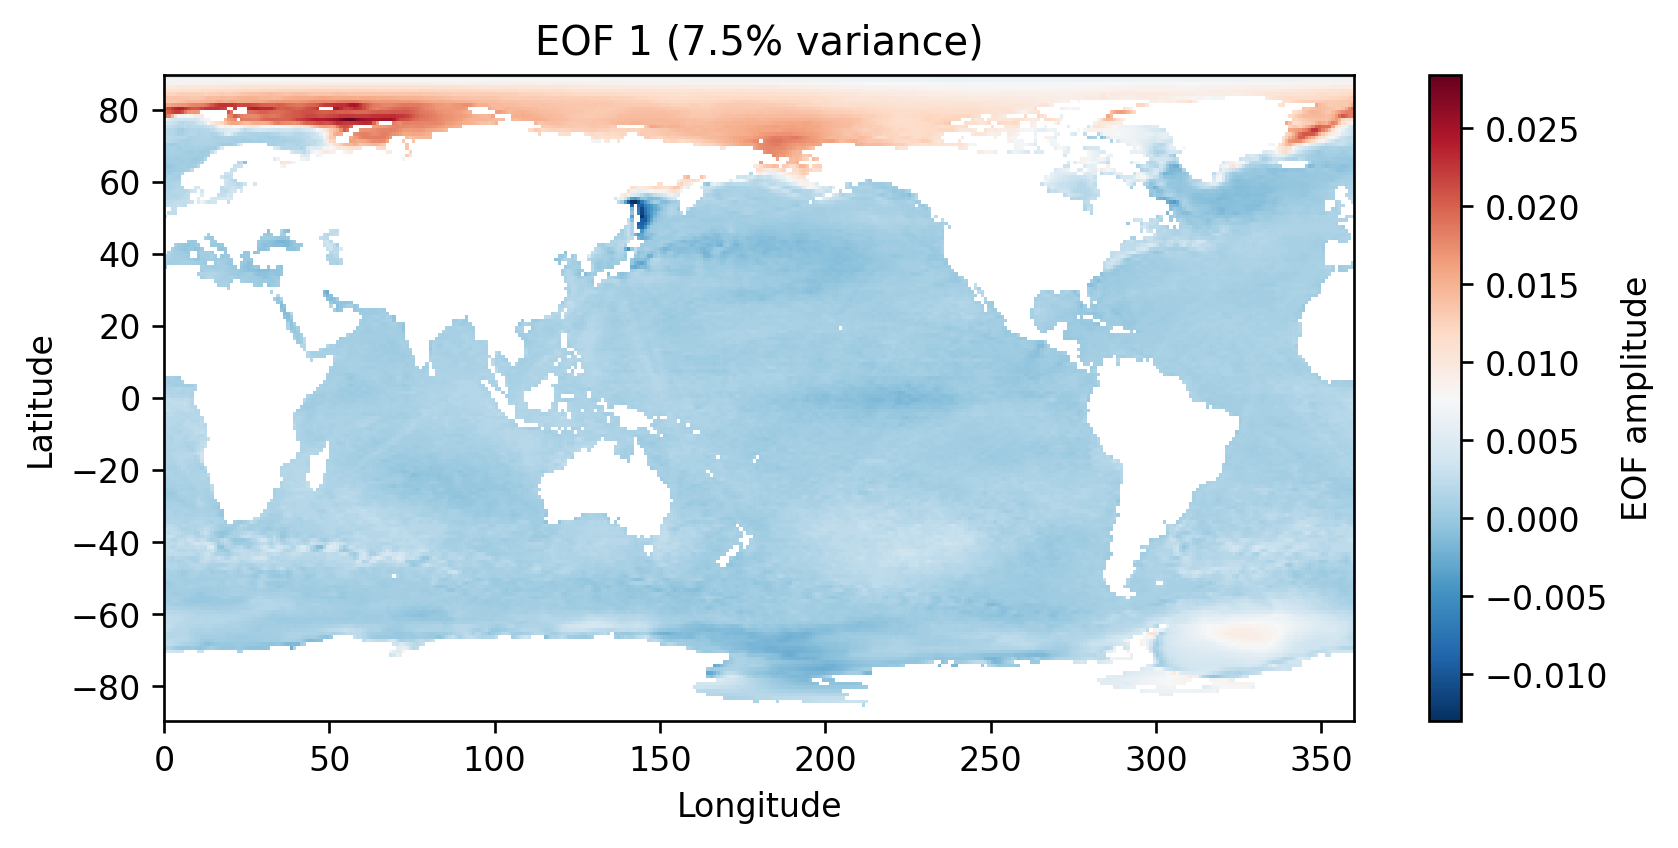

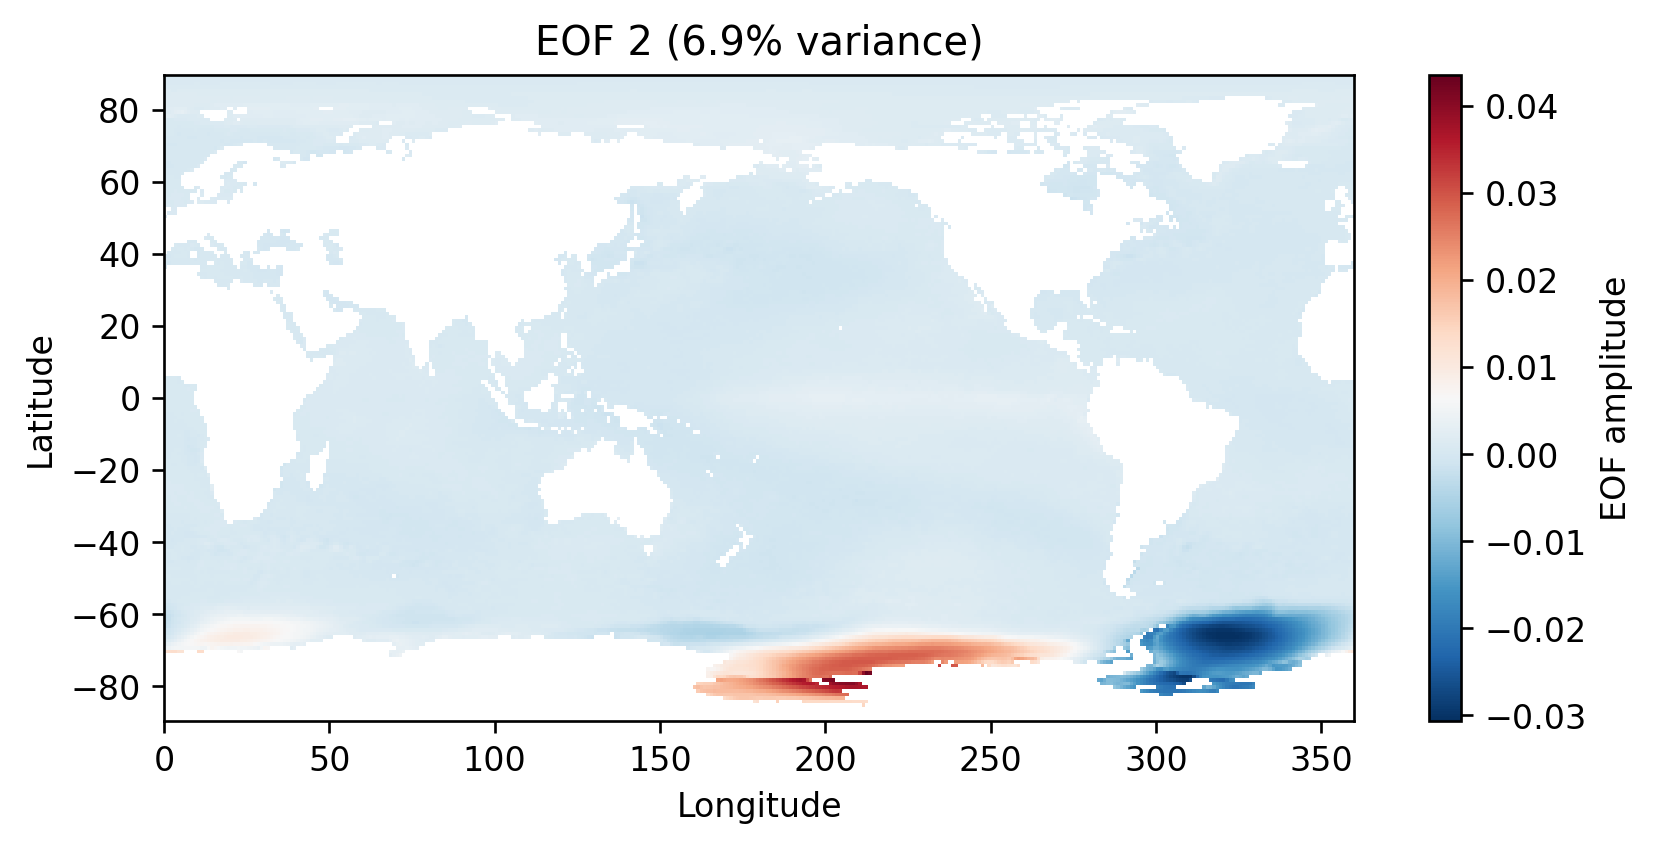

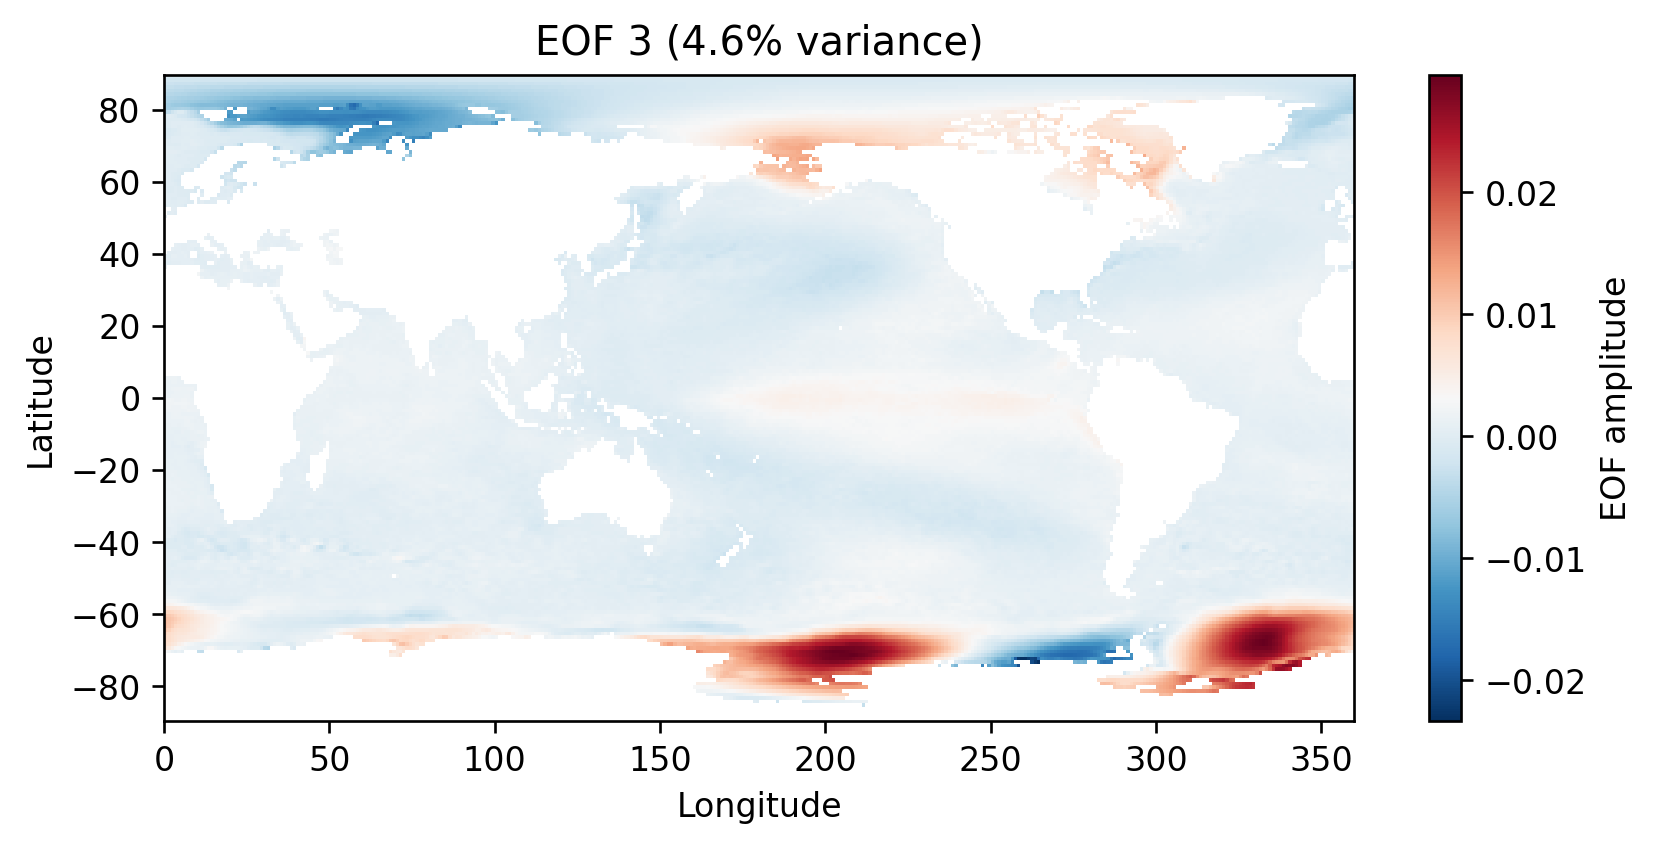

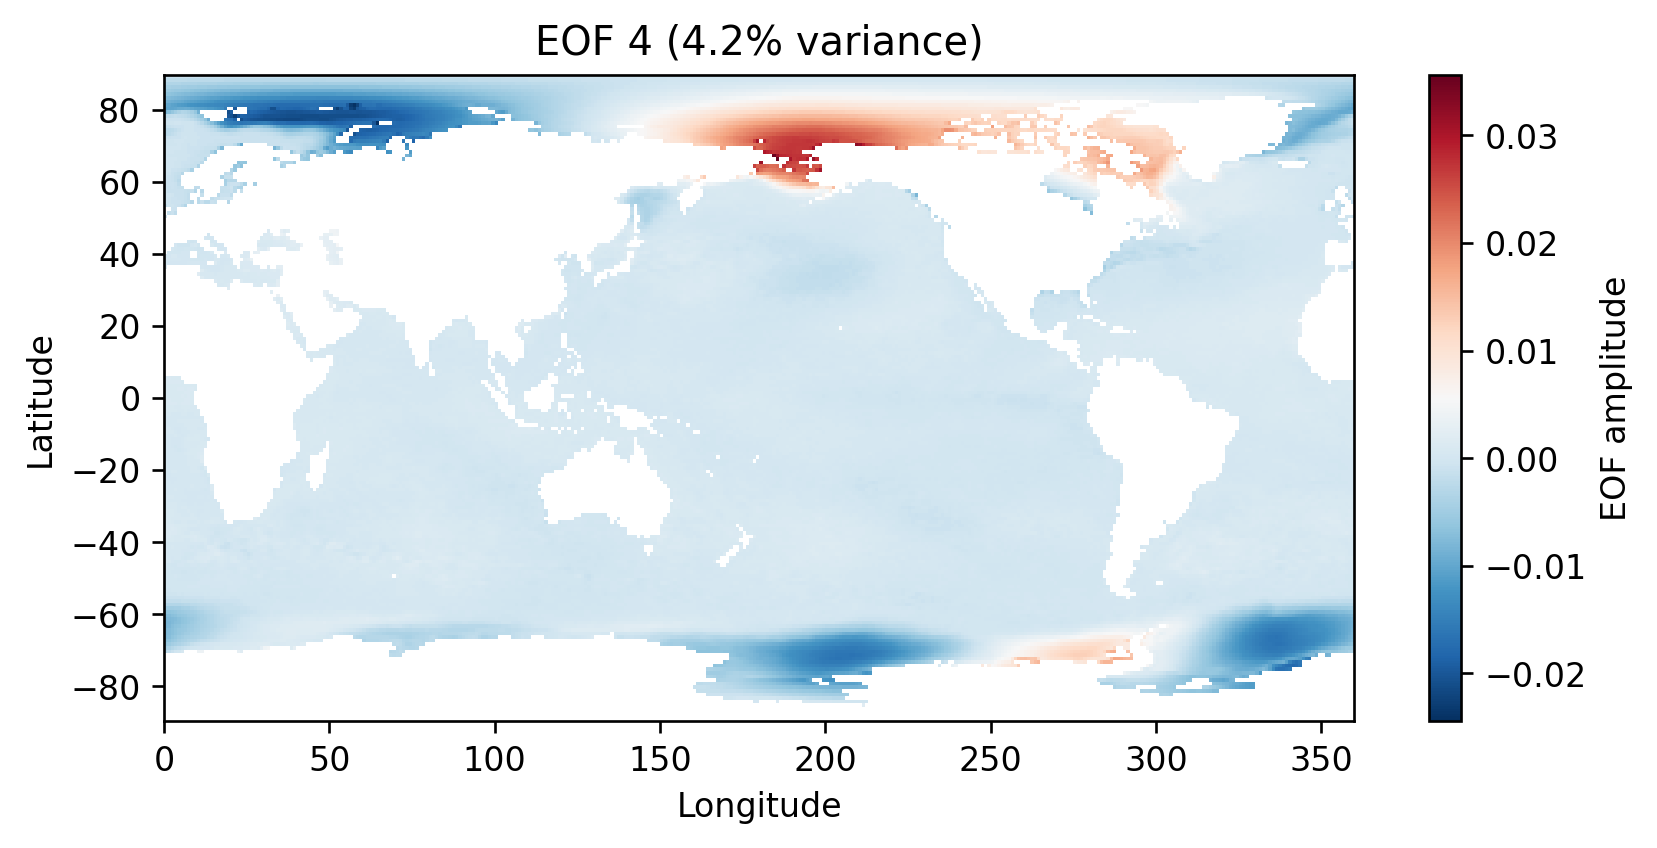

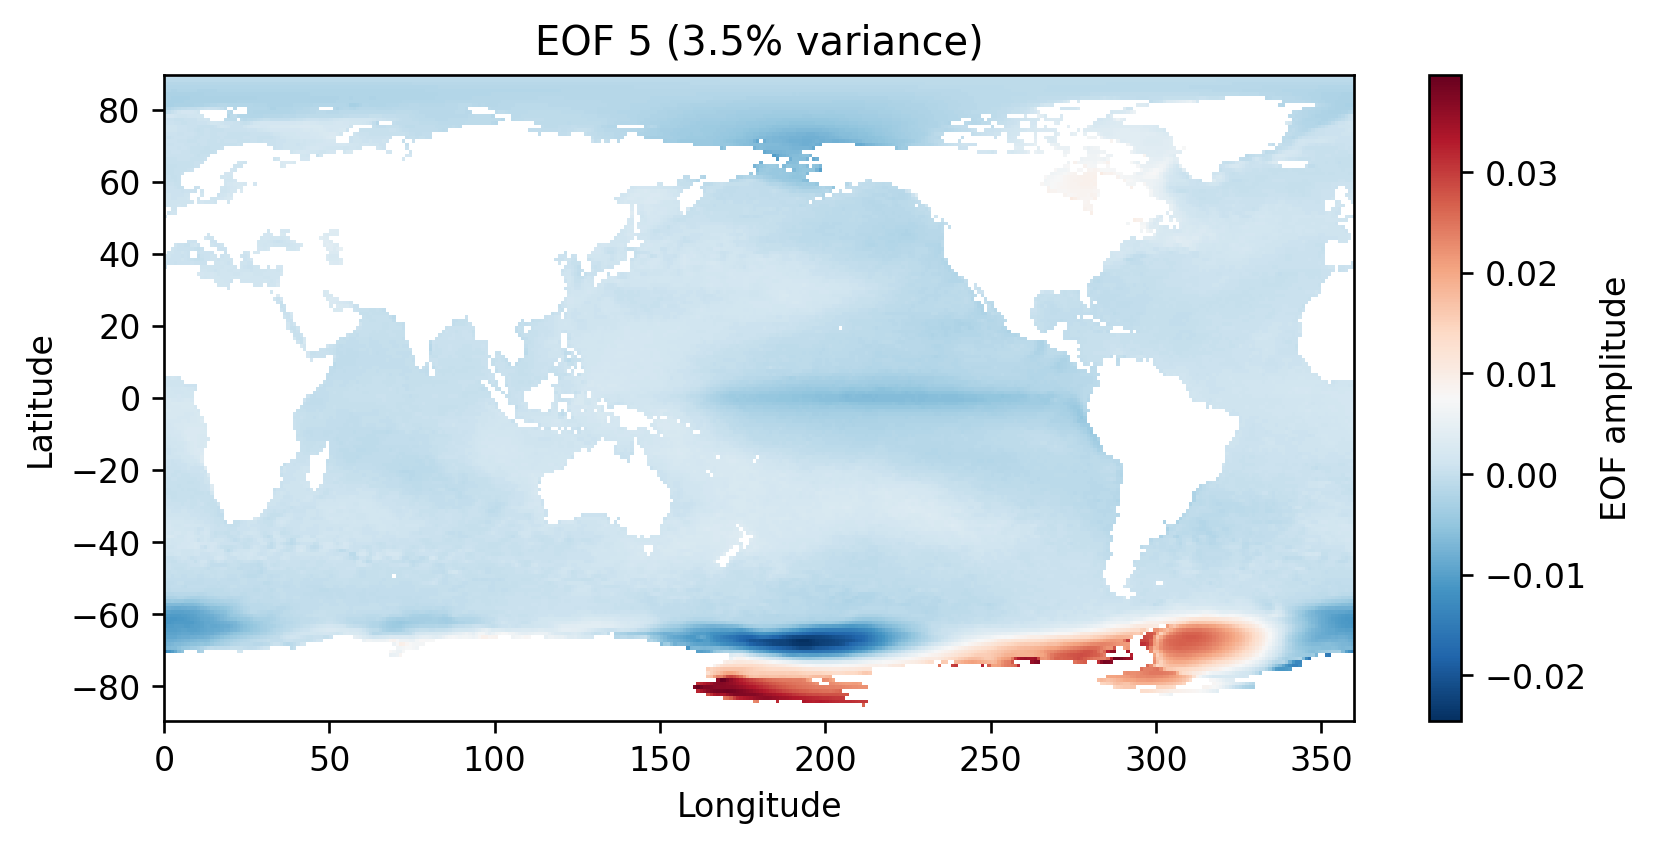

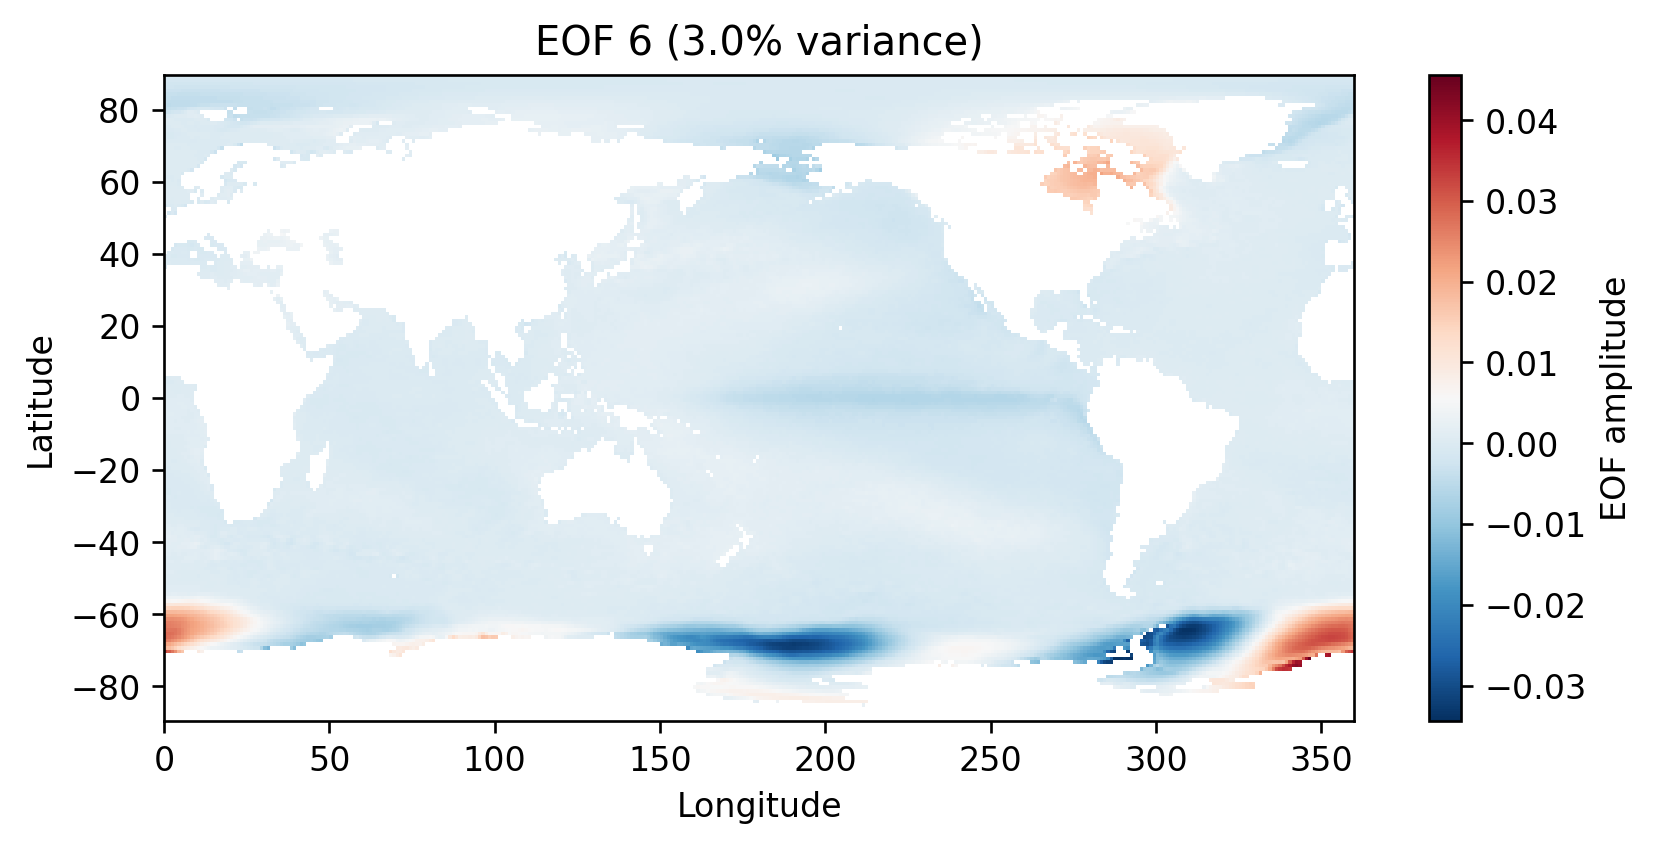

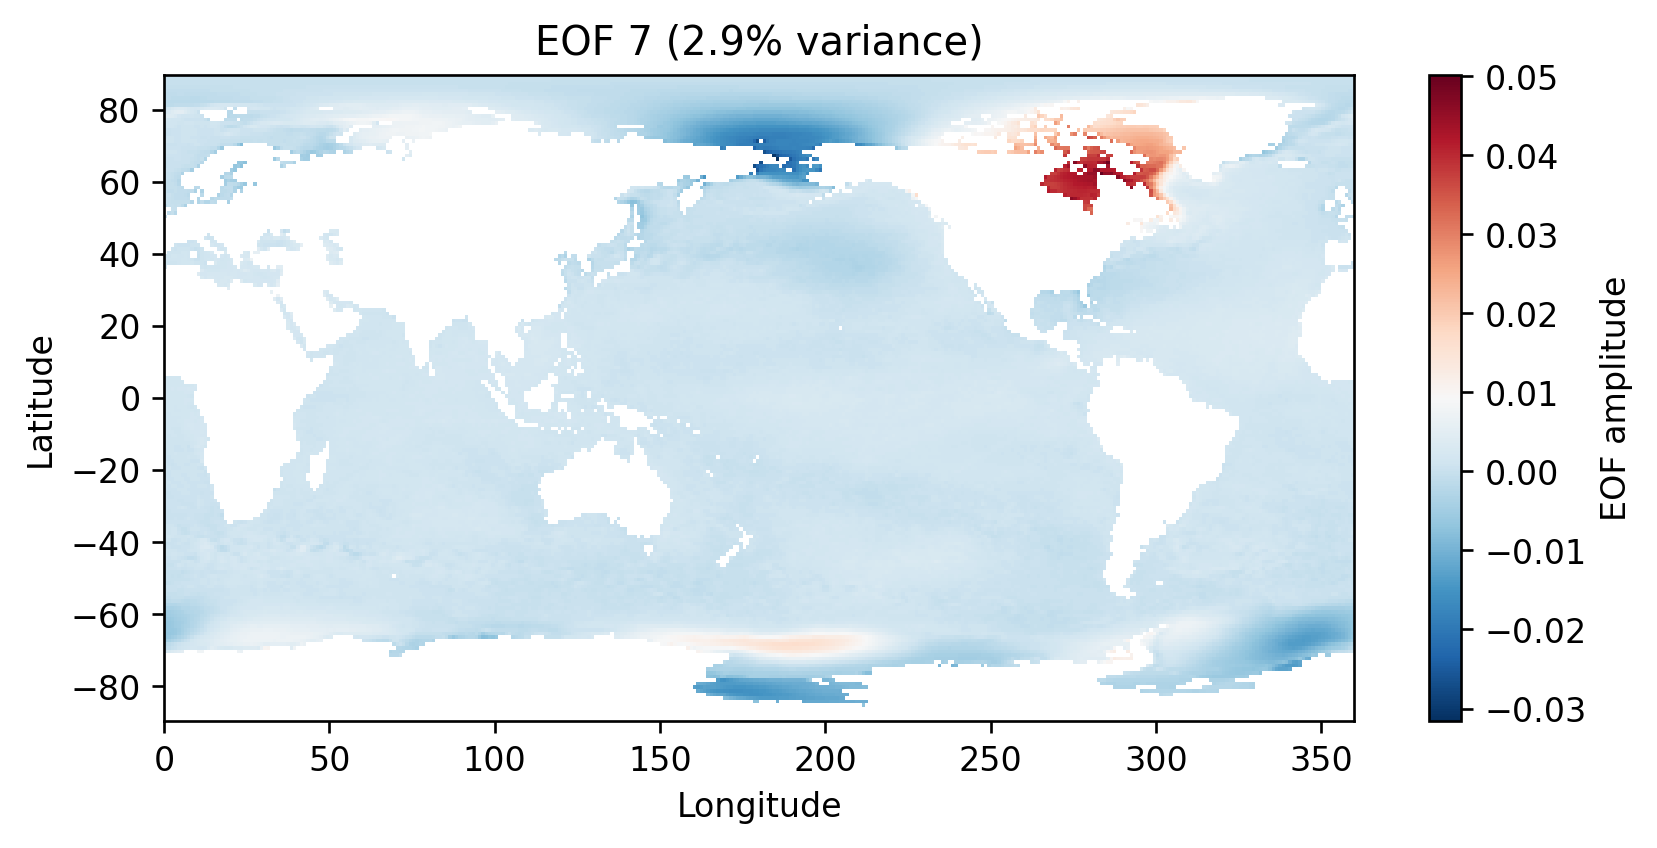

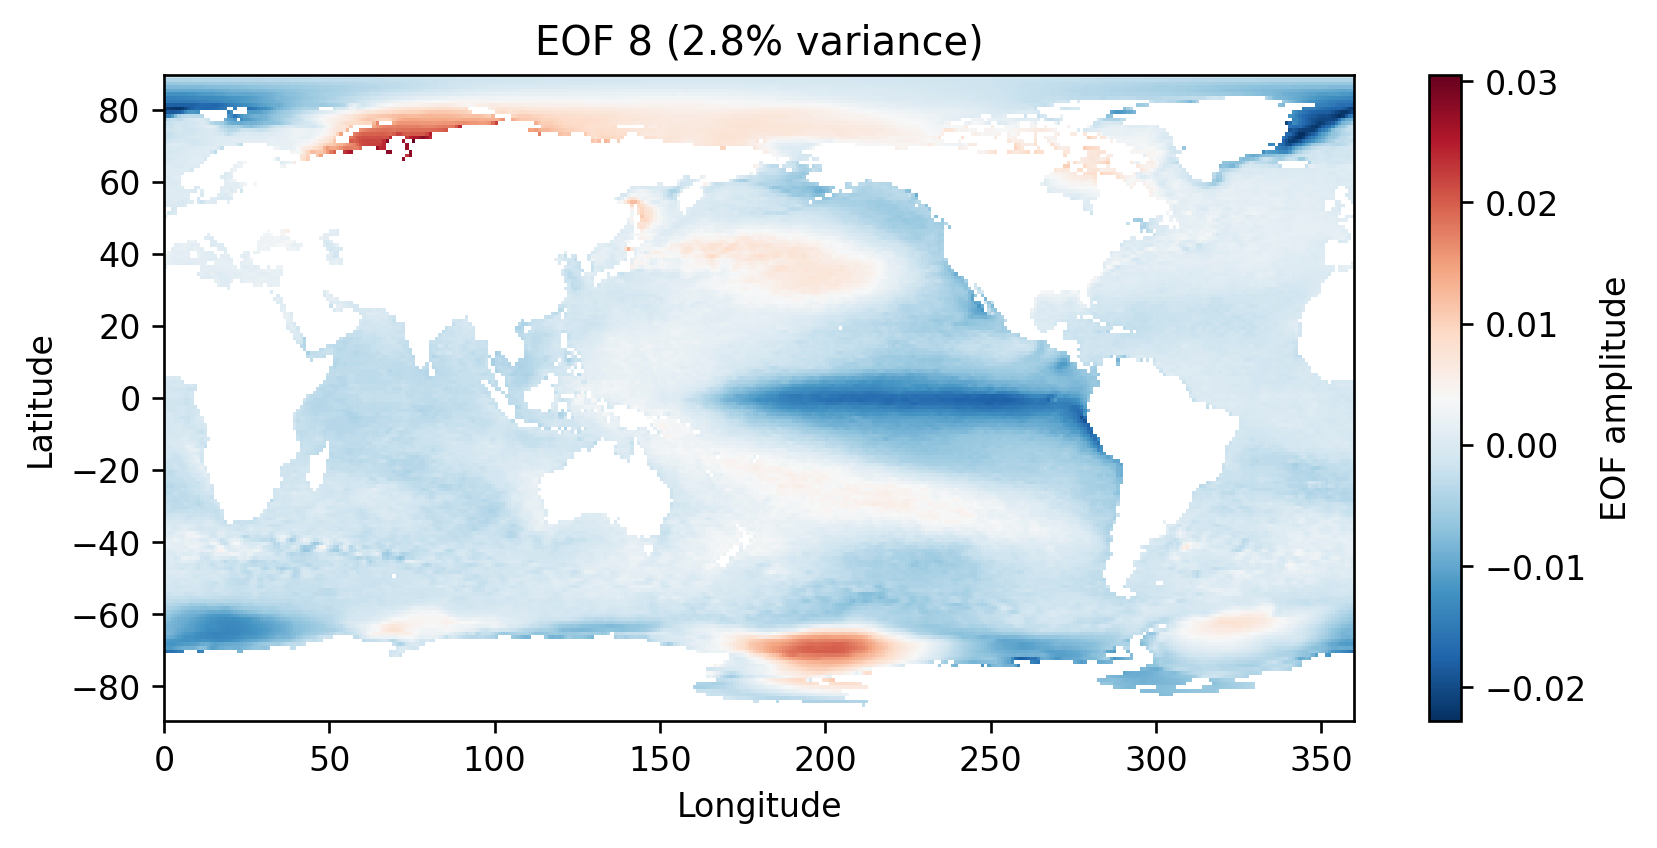

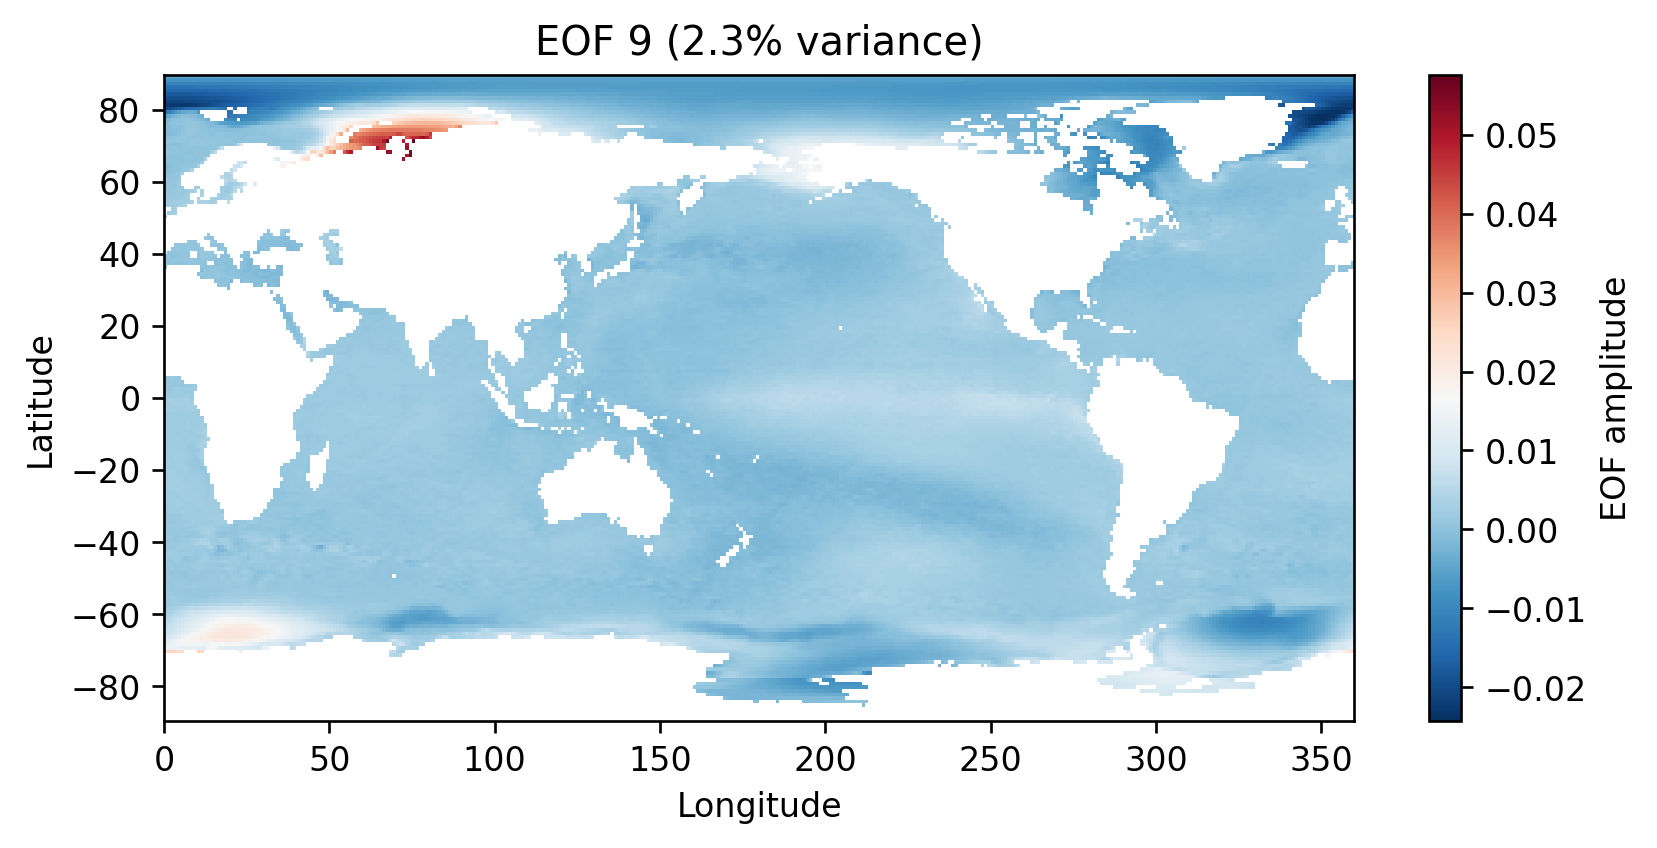

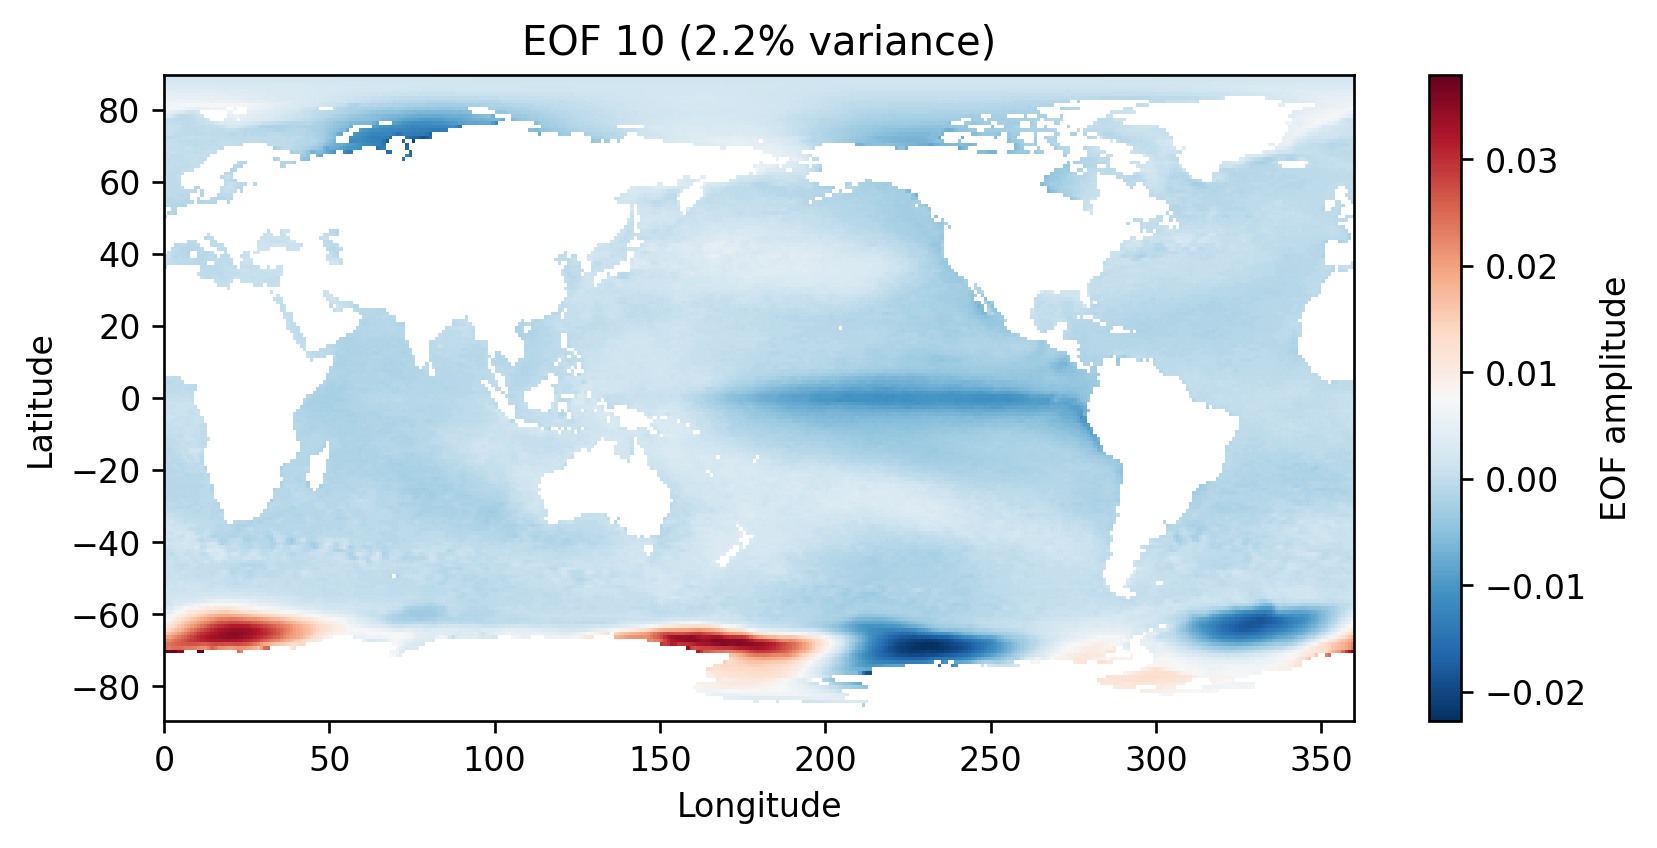

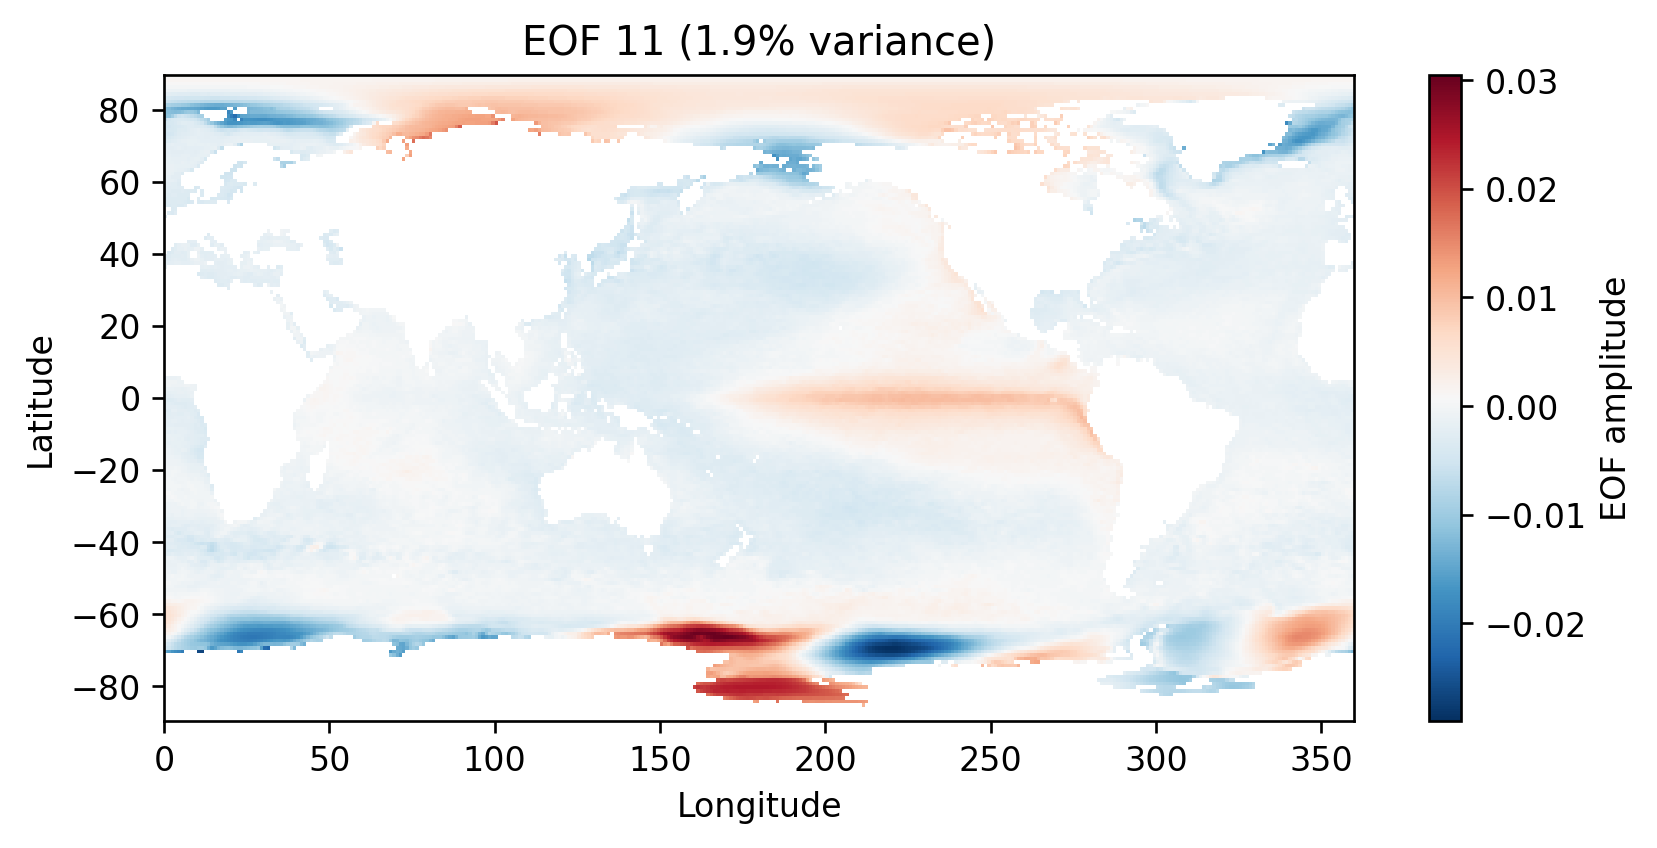

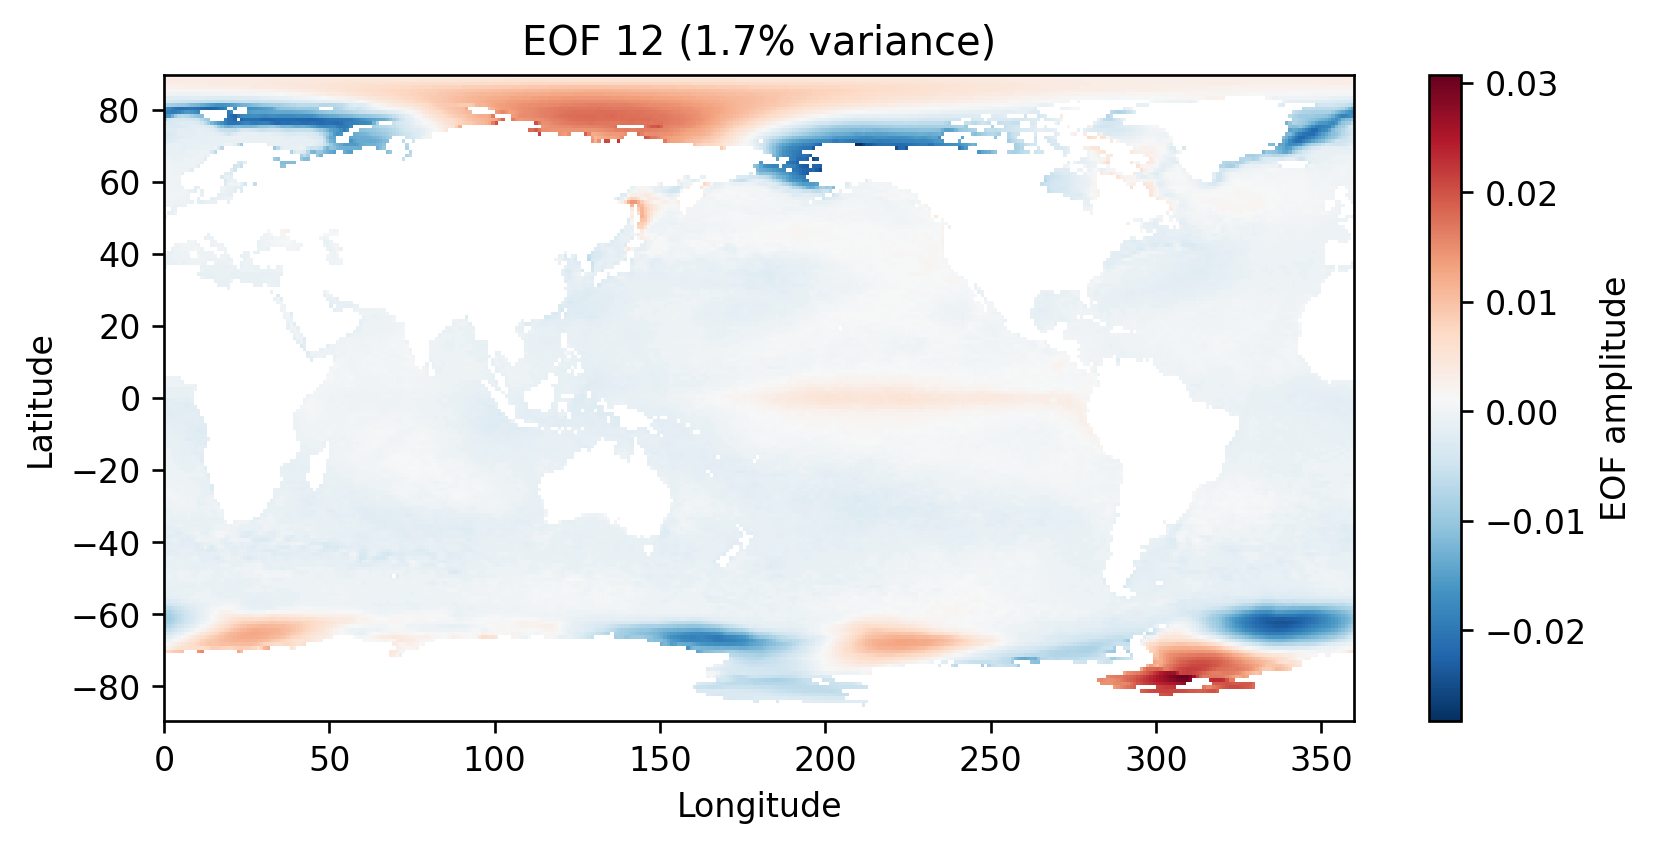

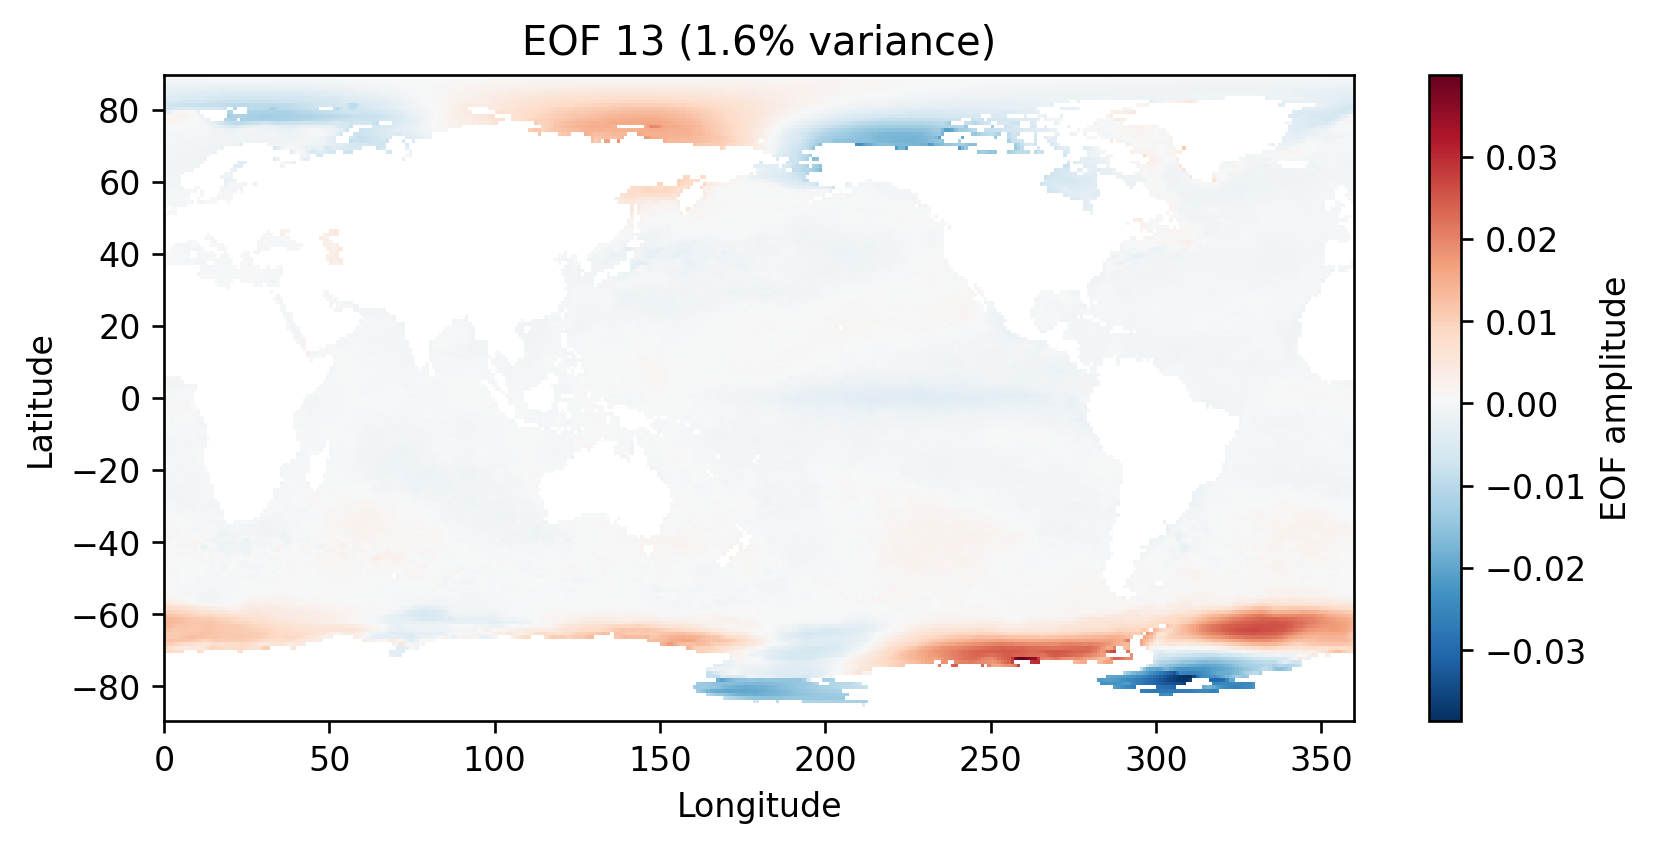

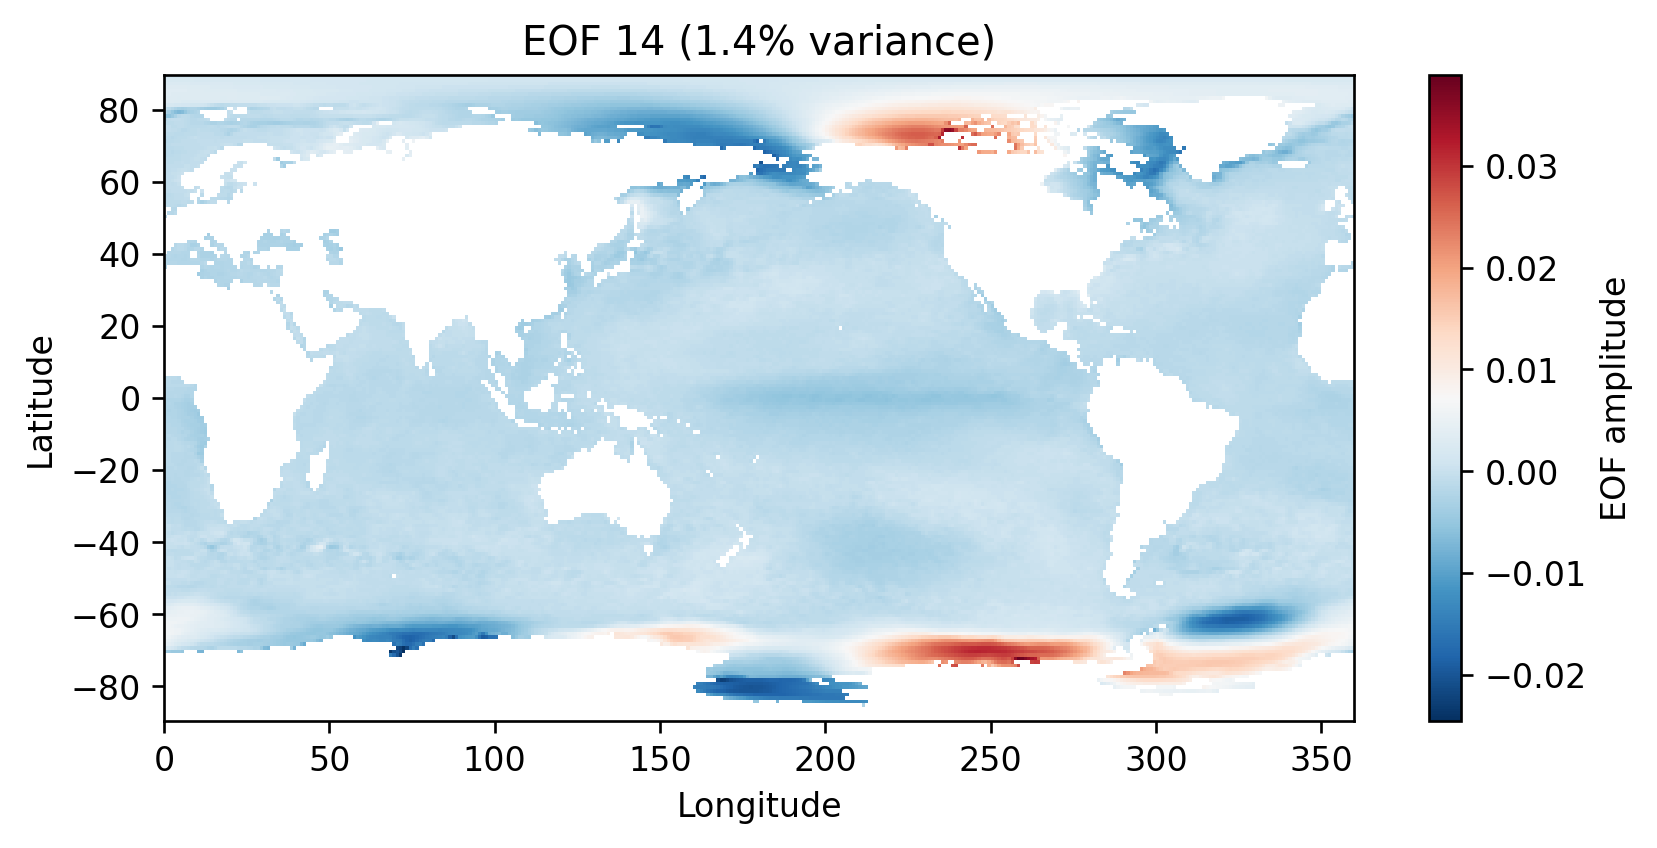

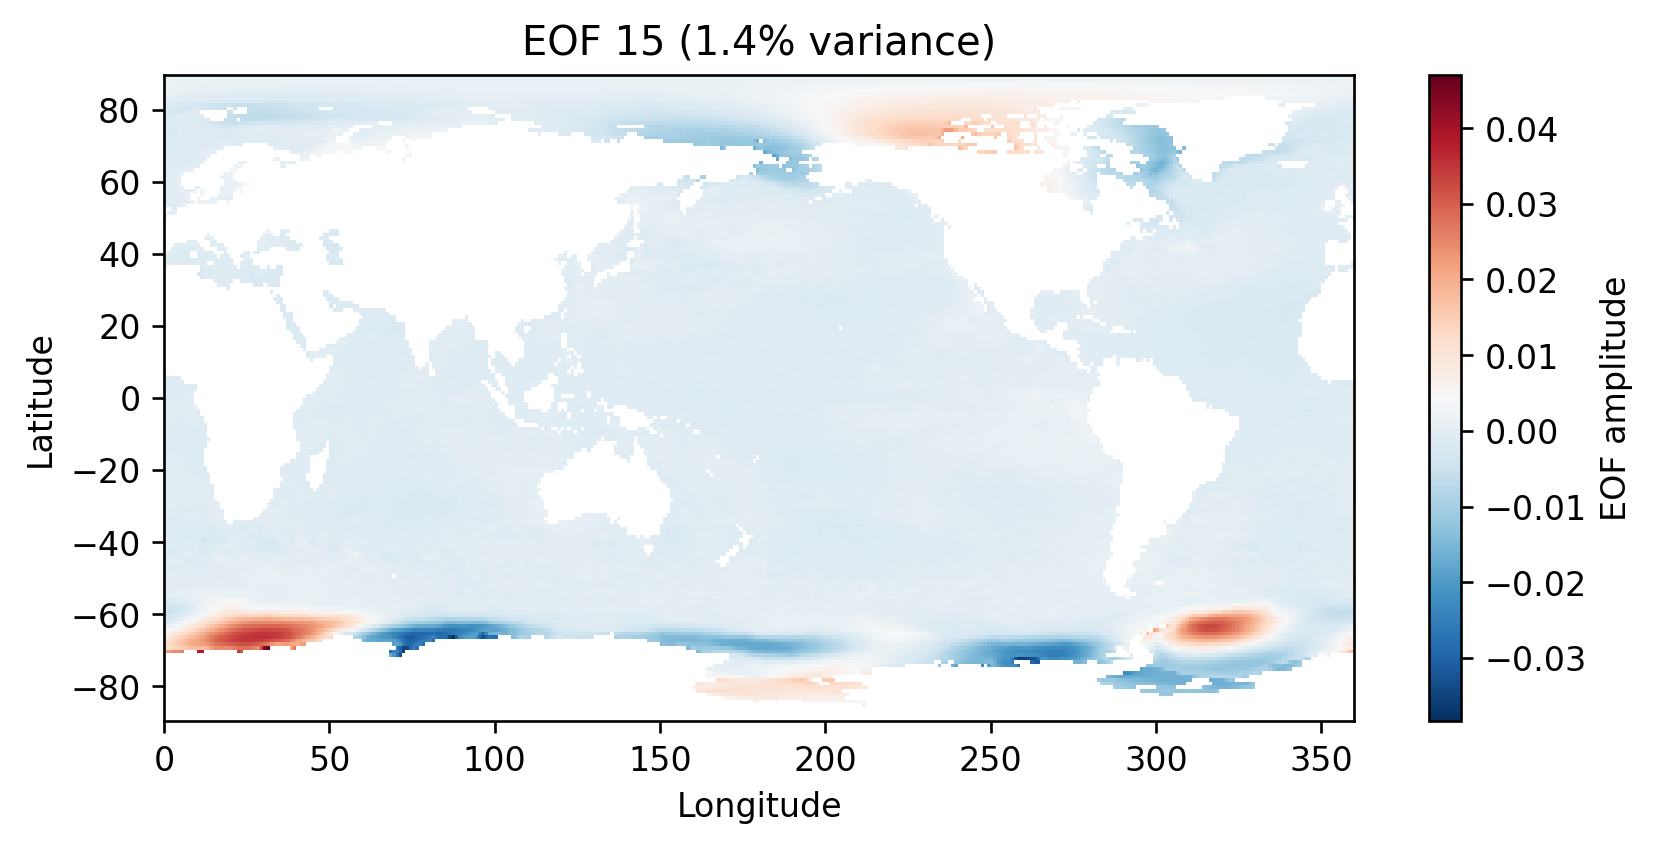

In [11]:
# ---------------------------
# Plot EOFs
# ---------------------------
for i in range(k):
    plt.figure(figsize=(8,3.5))
    im = plt.pcolormesh(
        sst_anom_train.longitude,
        sst_anom_train.latitude,
        EOF_maps[i],
        shading='auto',
        cmap='RdBu_r'
    )
    plt.title(f'EOF {i+1} ({explained_variance[i]*100:.1f}% variance)')
    plt.colorbar(im, label='EOF amplitude')
    plt.xlabel('Longitude'); plt.ylabel('Latitude')
    plt.show()


## Obtain PC amplitudes across training dataset

Projecting the full record onto the EOFS, then plotting a time series of the first PC

In [12]:
# PCs for all training days: time x EOF index
PCs_train = M_ocean_weighted_train @ EOFs_ocean.T  # shape: (n_days, k)
print("PC time series shape:", PCs_train.shape)  # should be (training_days, k)


PC time series shape: (25915, 15)


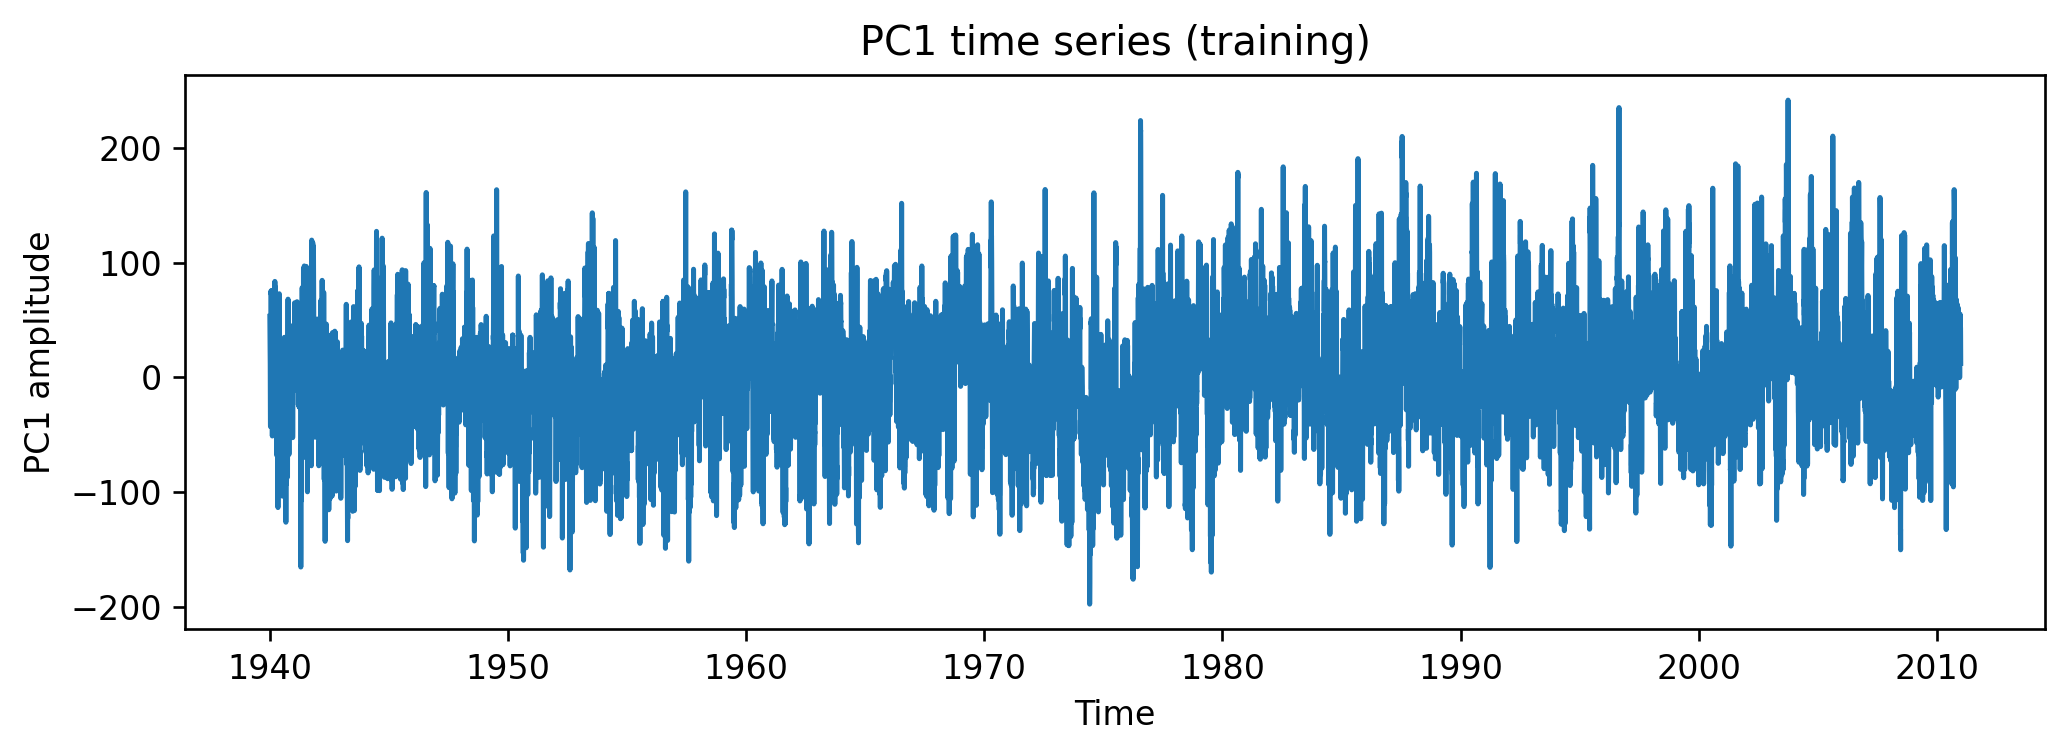

In [13]:
# Example: plot PC3 time series
plt.figure(figsize=(10,3))
plt.plot(sst_anom_train.time.values, PCs_train[:,2])
plt.xlabel('Time')
plt.ylabel('PC1 amplitude')
plt.title('PC1 time series (training)')
plt.show()


# Part 3: building a regression model using EOFs (training data only)

## define valid seasons in the training data

Since we are using Sept-Dec of year i-1 + Jan-Feb of year i

In [14]:

# sst_anom_train: no-leap anomalies (already masked + weighted if desired)
# PCs_train: shape (n_days_total, k)

# Define season start years: Sept-Nov of year Y predicting Dec Y - Feb Y+1
season_start_years = np.arange(1940, 2010)  # last full season ends Feb 2010

valid_seasons = []

for y in season_start_years:
    # Predictor: Sept 1 - Nov 30 of year y
    pred_dates = pd.date_range(start=f"{y}-09-01", end=f"{y}-11-30")
    # Target: Dec 1 of year y - Feb 28 of year y+1 (no Feb29)
    targ_dates = pd.date_range(start=f"{y}-12-01", end=f"{y+1}-02-28")

    # Check all dates exist in sst_anom_train.time
    sst_times = pd.DatetimeIndex(sst_anom_train.time.values)
    if set(pred_dates).issubset(sst_times) and set(targ_dates).issubset(sst_times):
        valid_seasons.append(y)

print("Number of valid seasons:", len(valid_seasons))


Number of valid seasons: 70


## build predictor/target arrays per season

Creating arrays of training and testing data for regression

In [15]:
X_list = []
Y_list = []

for y in valid_seasons:
    # Get indices for predictor/target dates
    pred_dates = pd.date_range(start=f"{y}-09-01", end=f"{y}-11-30")
    targ_dates = pd.date_range(start=f"{y}-12-01", end=f"{y+1}-02-28")

    X = PCs_train[np.isin(sst_anom_train.time.values, pred_dates), :]  # shape (~90, k)
    Y = PCs_train[np.isin(sst_anom_train.time.values, targ_dates), :]   # shape (~90, k)

    # Flatten to 1D: concatenate days × PCs → one sample per season
    X_list.append(X.flatten())
    Y_list.append(Y.flatten())

# Stack into (n_seasons, T_in*k) and (n_seasons, T_out*k)
X_train = np.vstack(X_list)
Y_train = np.vstack(Y_list)

print("X_train shape:", X_train.shape)  # (n_seasons, 90*k)
print("Y_train shape:", Y_train.shape)  # (n_seasons, 90*k)


X_train shape: (70, 1365)
Y_train shape: (70, 1350)


## train linear regression model

In [16]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, Y_train)

print("Regression coefficients shape:", reg.coef_.shape)
# Should be (T_out*k, T_in*k)


Regression coefficients shape: (1350, 1365)


# Part 4: Apply regression model to testing data to make SST predictions

### Project testing data onto training EOFs

Finding the magnitude of the PCs associated with the training EOFS for the testing data

In [17]:
PCs_test = M_ocean_weighted_test @ EOFs_ocean.T
print("PCs_test shape:", PCs_test.shape)


PCs_test shape: (4380, 15)


## define valid seasons in the testing data

Since we are using Sept-Dec of year i-1 + Jan-Feb of year i

In [18]:
season_start_years_test = np.arange(2010, 2023)   # ends Feb 2023

sst_times_test = pd.DatetimeIndex(sst_anom_test.time.values)
valid_test_seasons = []

for y in season_start_years_test:
    pred_dates = pd.date_range(start=f"{y}-09-01", end=f"{y}-11-30")

    # Only predict – no need to check target availability
    if set(pred_dates).issubset(sst_times_test):
        valid_test_seasons.append(y)

print("Valid test seasons:", len(valid_test_seasons))


Valid test seasons: 12


## build predictor arrays per season

Creating an array of the predictors for our prediction with the testing data.
This array will be the input X for the regression model, which we will us to predict SSTs for the testing data.

In [19]:
X_test_list = []
test_pred_date_list = []   # to keep track for reconstruction later

for y in valid_test_seasons:
    pred_dates = pd.date_range(start=f"{y}-09-01", end=f"{y}-11-30")

    X = PCs_test[np.isin(sst_anom_test.time.values, pred_dates), :]
    X_test_list.append(X.flatten())
    test_pred_date_list.append(pred_dates)

X_test = np.vstack(X_test_list)
print("X_test:", X_test.shape)


X_test: (12, 1365)


### apply regression to testing data

Using the Sept-Nov testing data to predict the Dec-Feb SSTs

In [20]:
Y_pred = reg.predict(X_test)
print("Predicted flattened PCs:", Y_pred.shape)


Predicted flattened PCs: (12, 1350)


# Part 5: convert the regression prediction back to an absolute SST prediction
1. 'Undo' the EOF to a full SST grid
2. 'Undo' the latitude weighting
3. reshape the grid back from one dimensional flattened (lat x lon x time) into 3 dimensions
4. Add back the climatology

### reshape into a x,y,t grid instead of a flattened vector for EOFS

In [21]:
# number of output days (Dec 1 – Feb 28)
T_out = Y_train.shape[1] // PCs_train.shape[1]
k = PCs_train.shape[1]

Y_pred_reshaped = Y_pred.reshape(len(valid_test_seasons), T_out, k)


### undo the latitude weights

In [22]:
sst_pred_anom_list = []

for i, y in enumerate(valid_test_seasons):
    PCs_season = Y_pred_reshaped[i]             # (T_out × k)

    # Reconstruct weighted anomalies
    M_weighted = PCs_season @ EOFs_ocean        # (T_out × N_ocean)

    # Unweight
    M_unweighted = M_weighted / weights_flat[np.newaxis, :]

    # Put back into full grid (including masked land)
    M_full = np.zeros((T_out, N))
    M_full[:, ocean_idx] = M_unweighted

    # reshape back to (T_out, lat, lon)
    sst_pred = M_full.reshape(T_out, nlat, nlon)
    sst_pred_anom_list.append(sst_pred)


### Add back climatology

In [23]:
# keep original climatology intact
clim_da = clim   # DO NOT overwrite this!

sst_pred_full_list = []

print("=== START RECONSTRUCTION OF FULL SST FROM ANOMALIES ===\n")
print("Climatology DataArray dims:", clim_da.dims)
print("Climatology shape:", clim_da.shape)
print("-------------------------------------------\n")

for i, y in enumerate(valid_test_seasons):

    print(f"\n=== Season {i} — Year {y} ===")

    # predicted anomalies
    sst_anom = sst_pred_anom_list[i]       # (T_out, lat, lon)
    print("Predicted anomaly array shape:", sst_anom.shape)

    # target dates
    targ_dates = pd.date_range(start=f"{y}-12-01", end=f"{y+1}-02-28")
    doy_list = [d.dayofyear for d in targ_dates]
    print("Target DOYs:", doy_list[:10], "... total =", len(doy_list))

    # Select climatology for these DOYs
    print("Selecting climatology for these DOYs...")
    try:
        clim_sel = clim_da.sel(dayofyear=doy_list).values
        print("Climatology selection shape:", clim_sel.shape)
    except Exception as e:
        print("ERROR selecting climatology:", e)
        raise

    # Check shape consistency
    if clim_sel.shape != sst_anom.shape:
        print("WARNING: Shape mismatch!")
        print("sst_anom:", sst_anom.shape)
        print("clim_sel:", clim_sel.shape)

    # Add climatology back
    sst_full = sst_anom + clim_sel
    print("Final reconstructed SST shape:", sst_full.shape)

    sst_pred_full_list.append(sst_full)

print("\n=== DONE reconstructing full SST ===")
print(f"Generated {len(sst_pred_full_list)} full SST predictions.")


=== START RECONSTRUCTION OF FULL SST FROM ANOMALIES ===

Climatology DataArray dims: ('dayofyear', 'latitude', 'longitude')
Climatology shape: (366, 180, 360)
-------------------------------------------


=== Season 0 — Year 2011 ===
Predicted anomaly array shape: (90, 180, 360)
Target DOYs: [335, 336, 337, 338, 339, 340, 341, 342, 343, 344] ... total = 90
Selecting climatology for these DOYs...
Climatology selection shape: (90, 180, 360)
Final reconstructed SST shape: (90, 180, 360)

=== Season 1 — Year 2012 ===
Predicted anomaly array shape: (90, 180, 360)
Target DOYs: [336, 337, 338, 339, 340, 341, 342, 343, 344, 345] ... total = 90
Selecting climatology for these DOYs...
Climatology selection shape: (90, 180, 360)
Final reconstructed SST shape: (90, 180, 360)

=== Season 2 — Year 2013 ===
Predicted anomaly array shape: (90, 180, 360)
Target DOYs: [335, 336, 337, 338, 339, 340, 341, 342, 343, 344] ... total = 90
Selecting climatology for these DOYs...
Climatology selection shape: (9

### Create one xarray of predicted SSTs with correct time stamps of predictions

Take seasonal predicted SST blocks, assign correct daily dates to each, stitch them together, and return a complete continuous time series of predicted SST fields as an xarray DataArray.

In [24]:

all_sst = []      # will hold (T_out, lat, lon) arrays
all_times = []    # will hold actual datetimes

for i, y in enumerate(valid_test_seasons):

    # predicted full SST for this season (shape: T_out, lat, lon)
    sst_full = sst_pred_full_list[i]

    # build corresponding target dates
    targ_dates = pd.date_range(start=f"{y}-12-01",
                               end=f"{y+1}-02-28")

    # sanity check
    if len(targ_dates) != sst_full.shape[0]:
        raise ValueError(f"Mismatch in T_out for year {y}")

    all_sst.append(sst_full)
    all_times.append(targ_dates)


# stack all seasons into one big array
data_np = np.concatenate(all_sst, axis=0)     # (total_days, lat, lon)

# flatten list of date ranges
times = np.concatenate(all_times)             # (total_days,)
sst_pred_da = xr.DataArray(
    data_np,
    dims=("time", "lat", "lon"),
    coords={
        "time": times,
        "lat": sst_anom_test.latitude.values,
        "lon": sst_anom_test.longitude.values,
    },
    name="sst_pred",
)

sst_pred_da # predicted SST dataset


<xarray.DataArray 'sst_pred' (time: 1080, lat: 180, lon: 360)> Size: 560MB
array([[[240.41940308, 240.42019653, 240.42088318, ..., 240.42671204,
         240.4236908 , 240.420578  ],
        [240.71769714, 240.68656921, 240.65512085, ..., 240.79937744,
         240.77313232, 240.74656677],
        [241.08312988, 241.02726746, 240.97180176, ..., 241.22210693,
         241.17944336, 241.1346283 ],
        ...,
        [249.28362944, 249.32347885, 249.36527816, ..., 249.13779479,
         249.18963478, 249.24005209],
        [248.60670735, 248.6421784 , 248.67741308, ..., 248.5165543 ,
         248.54561677, 248.57451373],
        [248.4079717 , 248.42373618, 248.43946223, ..., 248.36594276,
         248.37961569, 248.39325454]],

       [[240.9715271 , 240.97009277, 240.96864319, ..., 240.98751831,
         240.98146057, 240.97529602],
        [241.23574829, 241.20037842, 241.16471863, ..., 241.32119751,
         241.29423523, 241.26705933],
        [241.52401733, 241.46476746, 241.40614319, ..., 241.68389893,
         241.63360596, 241.58113098],
...
        [251.11496561, 251.17383322, 251.23176558, ..., 250.86574684,
         250.95475589, 251.04214755],
        [249.97129437, 249.99983348, 250.02774312, ..., 249.9060385 ,
         249.92680051, 249.94692664],
        [248.67487548, 248.68278495, 248.69034145, ..., 248.65418142,
         248.66107938, 248.66766479]],

       [[229.72059631, 229.72686768, 229.73309326, ..., 229.71044922,
         229.71328735, 229.71606445],
        [229.829422  , 229.79826355, 229.76683044, ..., 229.92739868,
         229.89459229, 229.86154175],
        [230.44848633, 230.3999176 , 230.3522644 , ..., 230.57998657,
         230.5403595 , 230.49673462],
        ...,
        [251.40128484, 251.45285145, 251.50335645, ..., 251.17068365,
         251.25373421, 251.33508123],
        [250.24439732, 250.26978567, 250.29461838, ..., 250.191293  ,
         250.20780917, 250.22375042],
        [249.08247416, 249.08963172, 249.09650125, ..., 249.06601894,
         249.07131975, 249.07634378]]], shape=(1080, 180, 360))
Coordinates:
  * time     (time) datetime64[ns] 9kB 2011-12-01 2011-12-02 ... 2023-02-28
  * lat      (lat) float64 1kB -89.24 -88.25 -87.25 -86.26 ... 87.25 88.25 89.24
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5

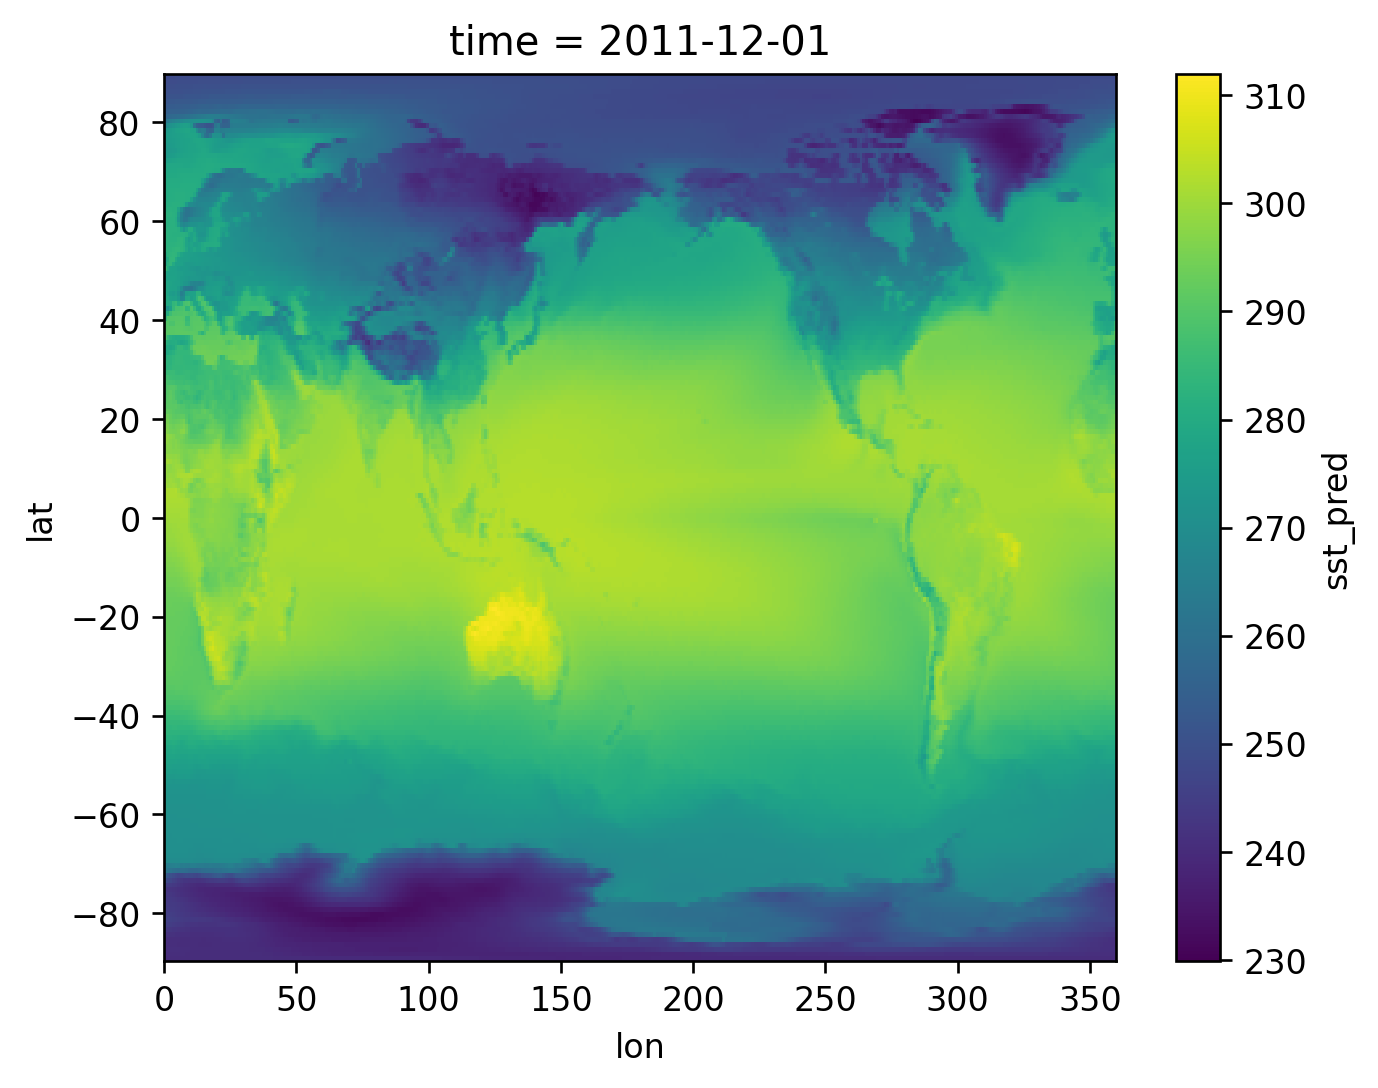

In [25]:
sst_pred_da.isel(time=0).plot()

# Part 5: assessing the accuracy of predicted SST

### Computing the error between the predicted and observed SSTs

Making sure the times are aligned correctly between the two datasets

In [26]:
# 1. Standardize names
sst_test_da = sst_test.rename({"latitude": "lat", "longitude": "lon"})

# 2. Align observed data to predicted times
sst_test_matched = sst_test_da.reindex(time=sst_pred_da.time)

# 3. Compute error
error = sst_pred_da - sst_test_matched


### Add land mask to prediction errors

This function will be used again when we persist anomalies as an alternative approach

In [27]:

def add_land_mask_to_sst_errors(pred_error):
    # ----------------------------------------------------------
    # 1. Load land mask
    # ----------------------------------------------------------
    land_mask_path = "/projects/GEOCLIM/el2358/projects/mask/land_mask.nc"
    print("Loading land mask:", land_mask_path)
    
    land_mask_ds = xr.open_dataset(land_mask_path)
    print("Land mask dataset:\n", land_mask_ds)
    
    # pick the variable inside (usually "sst")
    mask_var = "sst" if "sst" in land_mask_ds.data_vars else list(land_mask_ds.data_vars)[0]
    land_mask = land_mask_ds[mask_var]
    print("Selected mask var:", mask_var)
    print("Mask shape:", land_mask.shape)
    print("Mask dims:", land_mask.dims)
    
    # ----------------------------------------------------------
    # 2. Standardize dimension names to match the error data
    # ----------------------------------------------------------
    rename_map = {}
    if "latitude" in land_mask.dims:
        rename_map["latitude"] = "lat"
    if "longitude" in land_mask.dims:
        rename_map["longitude"] = "lon"
    
    if rename_map:
        print("Renaming land mask dims:", rename_map)
        land_mask = land_mask.rename(rename_map)
    
    print("Mask dims after rename:", land_mask.dims)
    
    # ----------------------------------------------------------
    # 3. Convert mask to binary (1=ocean, 0=land)
    # ----------------------------------------------------------
    binary_mask = xr.where(np.isfinite(land_mask), 1.0, 0.0)
    print("Binary mask min/max:", float(binary_mask.min()), float(binary_mask.max()))
    
    # ----------------------------------------------------------
    # 4. Interpolate mask to the error grid if needed
    # ----------------------------------------------------------
    print("Error dims:", pred_error.dims)
    print("Error shape:", pred_error.shape)
    
    try:
        print("Interpolating mask to error grid...")
        mask_on_grid = binary_mask.interp(
            lat=pred_error.lat,
            lon=pred_error.lon,
            method="nearest"
        )
    except Exception as e:
        print("Interpolation failed, broadcasting instead:", e)
        mask_on_grid = binary_mask.broadcast_like(pred_error.isel(time=0))
    
    print("Mask on grid shape:", mask_on_grid.shape)
    
    # ----------------------------------------------------------
    # 5. Expand mask along time dimension
    # ----------------------------------------------------------
    if "time" not in mask_on_grid.dims:
        print("Expanding mask over time...")
        mask_expanded = mask_on_grid.broadcast_like(pred_error)
    else:
        mask_expanded = mask_on_grid
    
    print("Mask expanded shape:", mask_expanded.shape)
    
    # ----------------------------------------------------------
    # 6. Apply mask to error field
    # ----------------------------------------------------------
    print("Applying mask...")
    error_masked = pred_error.where(mask_expanded == 1)
    
    print("Masked error min/max:", float(error_masked.min()), float(error_masked.max()))
    print("error_masked dims:", error_masked.dims)
    print("error_masked shape:", error_masked.shape)
    return error_masked

error_masked = add_land_mask_to_sst_errors(error)


Loading land mask: /projects/GEOCLIM/el2358/projects/mask/land_mask.nc
Land mask dataset:
 <xarray.Dataset> Size: 261kB
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    time     object 8B ...
    region   int64 8B ...
    abbrevs  <U3 12B ...
    names    <U4 16B ...
Data variables:
    sst      (lat, lon) float32 259kB ...
Selected mask var: sst
Mask shape: (180, 360)
Mask dims: ('lat', 'lon')
Mask dims after rename: ('lat', 'lon')
Binary mask min/max: 0.0 1.0
Error dims: ('time', 'lat', 'lon')
Error shape: (1080, 180, 360)
Interpolating mask to error grid...
Mask on grid shape: (180, 360)
Expanding mask over time...
Mask expanded shape: (1080, 180, 360)
Applying mask...
Masked error min/max: -36.83416070990236 43.4783991468089
error_masked dims: ('time', 'lat', 'lon')
error_masked shape: (1080, 180, 360)


### Compute RMSE 

In [28]:
# RMSE

rmse_daily = np.sqrt((error_masked**2).mean(dim=["lat", "lon"]))
rmse_total = np.sqrt((error_masked**2).mean())

print("RMSE total:", float(rmse_total))
print("RMSE_daily shape:", rmse_daily.shape)

RMSE total: 2.49284941115108
RMSE_daily shape: (1080,)


# Part 6: Make SST predictions with persisting anomalies approach

We will ultimately compare EOF regression approach to canonical persisting anomaly approach

### Function to persist anomalies in the testing dataset 

Take the November 30th anomaly from the training dataset climatology and persist that anomaly through the rest of the season

In [29]:

def build_persistence_predictions(sst_test, clim, season_years):

    print("\n[DEBUG] Standardizing dims...")
    sst_test_da = sst_test.rename({"latitude": "lat", "longitude": "lon"})
    clim_da = clim.rename({"latitude": "lat", "longitude": "lon"})

    print(f"[DEBUG] sst_test_da dims: {sst_test_da.dims}")
    print(f"[DEBUG] clim_da dims: {clim_da.dims}")

    pred_blocks = []
    time_blocks = []

    for y in season_years:
        print("\n----------------------------------------")
        print(f"[DEBUG] Processing season {y} -> {y+1}")
        print("----------------------------------------")

        nov30 = pd.Timestamp(f"{y}-11-30")
        print(f"[DEBUG] Nov 30 timestamp: {nov30}")

        try:
            sst_nov30 = sst_test_da.sel(time=nov30)
        except KeyError:
            print(f"[WARN] Nov 30 {nov30.date()} not found in sst_test. Skipping season {y}.")
            continue

        if sst_nov30.isnull().all():
            print(f"[WARN] Nov 30 {nov30.date()} exists but all-NaN. Skipping season {y}.")
            continue

        print(f"[DEBUG] sst_nov30 shape: {sst_nov30.shape}")

        doy = nov30.dayofyear
        clim_nov30 = clim_da.sel(dayofyear=doy)
        print(f"[DEBUG] clim_nov30 shape: {clim_nov30.shape}")

        nov30_anom = sst_nov30 - clim_nov30
        print(f"[DEBUG] nov30_anom shape: {nov30_anom.shape}")

        targ_dates = pd.date_range(start=f"{y}-12-01", end=f"{y+1}-02-28")
        print(f"[DEBUG] number of winter days: {len(targ_dates)}")

        doy_list = [d.dayofyear for d in targ_dates]
        clim_winter = clim_da.sel(dayofyear=doy_list)

        print(f"[DEBUG] clim_winter dims before reassignment: {clim_winter.dims}")

        # -------------------------------------------------------
        # FIXED PART
        # -------------------------------------------------------
        clim_winter_time = (
            clim_winter
            .assign_coords(time=("dayofyear", targ_dates))  # add new time coordinate
            .swap_dims({"dayofyear": "time"})               # replace dim
            .drop_vars("dayofyear")                         # remove leftover coord
            .transpose("time", "lat", "lon")                # now valid
        )
        # -------------------------------------------------------

        print(f"[DEBUG] clim_winter_time dims after reassignment: {clim_winter_time.dims}")

        sst_pred_block = clim_winter_time + nov30_anom
        print(f"[DEBUG] sst_pred_block shape: {sst_pred_block.shape}")

        sst_pred_block = sst_pred_block.reset_coords(drop=True)

        pred_blocks.append(sst_pred_block)
        time_blocks.append(targ_dates)

    if len(pred_blocks) == 0:
        print("[WARN] No seasons produced predictions. Returning None.")
        return None

    print("\n[DEBUG] Concatenating blocks...")
    sst_pred_persistence = xr.concat(pred_blocks, dim="time", join="override")

    full_time = np.concatenate([np.array(t) for t in time_blocks])
    sst_pred_persistence = sst_pred_persistence.assign_coords(time=("time", full_time))

    sst_pred_persistence.name = "sst_pred_persistence"
    print("\n[DEBUG] Final persistence prediction:")
    print(sst_pred_persistence)

    return sst_pred_persistence


In [30]:
season_years = np.arange(2011, 2023)
sst_pred = build_persistence_predictions(sst_test, clim, season_years)


[DEBUG] Standardizing dims...
[DEBUG] sst_test_da dims: ('time', 'lat', 'lon')
[DEBUG] clim_da dims: ('dayofyear', 'lat', 'lon')

----------------------------------------
[DEBUG] Processing season 2011 -> 2012
----------------------------------------
[DEBUG] Nov 30 timestamp: 2011-11-30 00:00:00
[DEBUG] sst_nov30 shape: (180, 360)
[DEBUG] clim_nov30 shape: (180, 360)
[DEBUG] nov30_anom shape: (180, 360)
[DEBUG] number of winter days: 90
[DEBUG] clim_winter dims before reassignment: ('dayofyear', 'lat', 'lon')
[DEBUG] clim_winter_time dims after reassignment: ('time', 'lat', 'lon')
[DEBUG] sst_pred_block shape: (90, 180, 360)

----------------------------------------
[DEBUG] Processing season 2012 -> 2013
----------------------------------------
[DEBUG] Nov 30 timestamp: 2012-11-30 00:00:00
[DEBUG] sst_nov30 shape: (180, 360)
[DEBUG] clim_nov30 shape: (180, 360)
[DEBUG] nov30_anom shape: (180, 360)
[DEBUG] number of winter days: 90
[DEBUG] clim_winter dims before reassignment: ('dayofy

### Align times between predicted and observed SSTs and calculate error

In [31]:
common_times = np.intersect1d(sst_pred.time.values, sst_test_da.time.values)
sst_pred_common = sst_pred.sel(time=common_times)
sst_test_common = sst_test_da.sel(time=common_times)
error_persist = sst_pred_common - sst_test_common


### Mask land in the errors 

Using the same function as before with the EOF regression approach

In [32]:
error_masked_persist = add_land_mask_to_sst_errors(error_persist)

Loading land mask: /projects/GEOCLIM/el2358/projects/mask/land_mask.nc
Land mask dataset:
 <xarray.Dataset> Size: 261kB
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    time     object 8B ...
    region   int64 8B ...
    abbrevs  <U3 12B ...
    names    <U4 16B ...
Data variables:
    sst      (lat, lon) float32 259kB ...
Selected mask var: sst
Mask shape: (180, 360)
Mask dims: ('lat', 'lon')
Mask dims after rename: ('lat', 'lon')
Binary mask min/max: 0.0 1.0
Error dims: ('time', 'lat', 'lon')
Error shape: (1021, 180, 360)
Interpolating mask to error grid...
Mask on grid shape: (180, 360)
Expanding mask over time...
Mask expanded shape: (1021, 180, 360)
Applying mask...
Masked error min/max: -40.986602783203125 45.0390625
error_masked dims: ('time', 'lat', 'lon')
error_masked shape: (1021, 180, 360)


### RMSE

In [33]:
rmse_daily = np.sqrt((error_masked_persist**2).mean(dim=["lat", "lon"]))
rmse_total = np.sqrt((error_masked_persist**2).mean())

print("RMSE total:", float(rmse_total))
print("RMSE_daily shape:", rmse_daily.shape)

RMSE total: 2.9111640453338623
RMSE_daily shape: (1021,)


# Part 7: comparing prediction errors between two approaches

In [34]:
rmse_persist =  np.sqrt((error_masked_persist**2))
rmse_eof = np.sqrt((error_masked**2))

### Monthly RMSE and absolute error

In [41]:

# ---------------------------------------------
# Compute DJF monthly means of RMSE and absolute error 
# ---------------------------------------------
def monthly_mean(da, month):
    return da.sel(time=da['time.month'] == month).mean('time')

# ----- monthly mean RMSE -----
# Row 1: persisted anomalies
dec_p = monthly_mean(rmse_persist, 12)
jan_p = monthly_mean(rmse_persist, 1)
feb_p = monthly_mean(rmse_persist, 2)

# Row 2: EOF regression
dec_e = monthly_mean(rmse_eof, 12)
jan_e = monthly_mean(rmse_eof, 1)
feb_e = monthly_mean(rmse_eof, 2)

# Force data loading to avoid Cartopy stalling
dec_p = dec_p.load()
jan_p = jan_p.load()
feb_p = feb_p.load()

dec_e = dec_e.load()
jan_e = jan_e.load()
feb_e = feb_e.load()

# ------- monthly mean error -----
# Row 1: persisted anomalies
dec_p_error = monthly_mean(error_masked_persist, 12)
jan_p_error = monthly_mean(error_masked_persist, 1)
feb_p_error = monthly_mean(error_masked_persist, 2)

# Row 2: EOF regression
dec_e_error = monthly_mean(error_masked, 12)
jan_e_error = monthly_mean(error_masked, 1)
feb_e_error = monthly_mean(error_masked, 2)

# Force data loading to avoid Cartopy stalling
dec_p_error = dec_p_error.load()
jan_p_error = jan_p_error.load()
feb_p_error = feb_p_error.load()

dec_e_error = dec_e_error.load()
jan_e_error = jan_e_error.load()
feb_e_error = feb_e_error.load()



### Plotting function

/tmp/ipykernel_3575049/2465861257.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


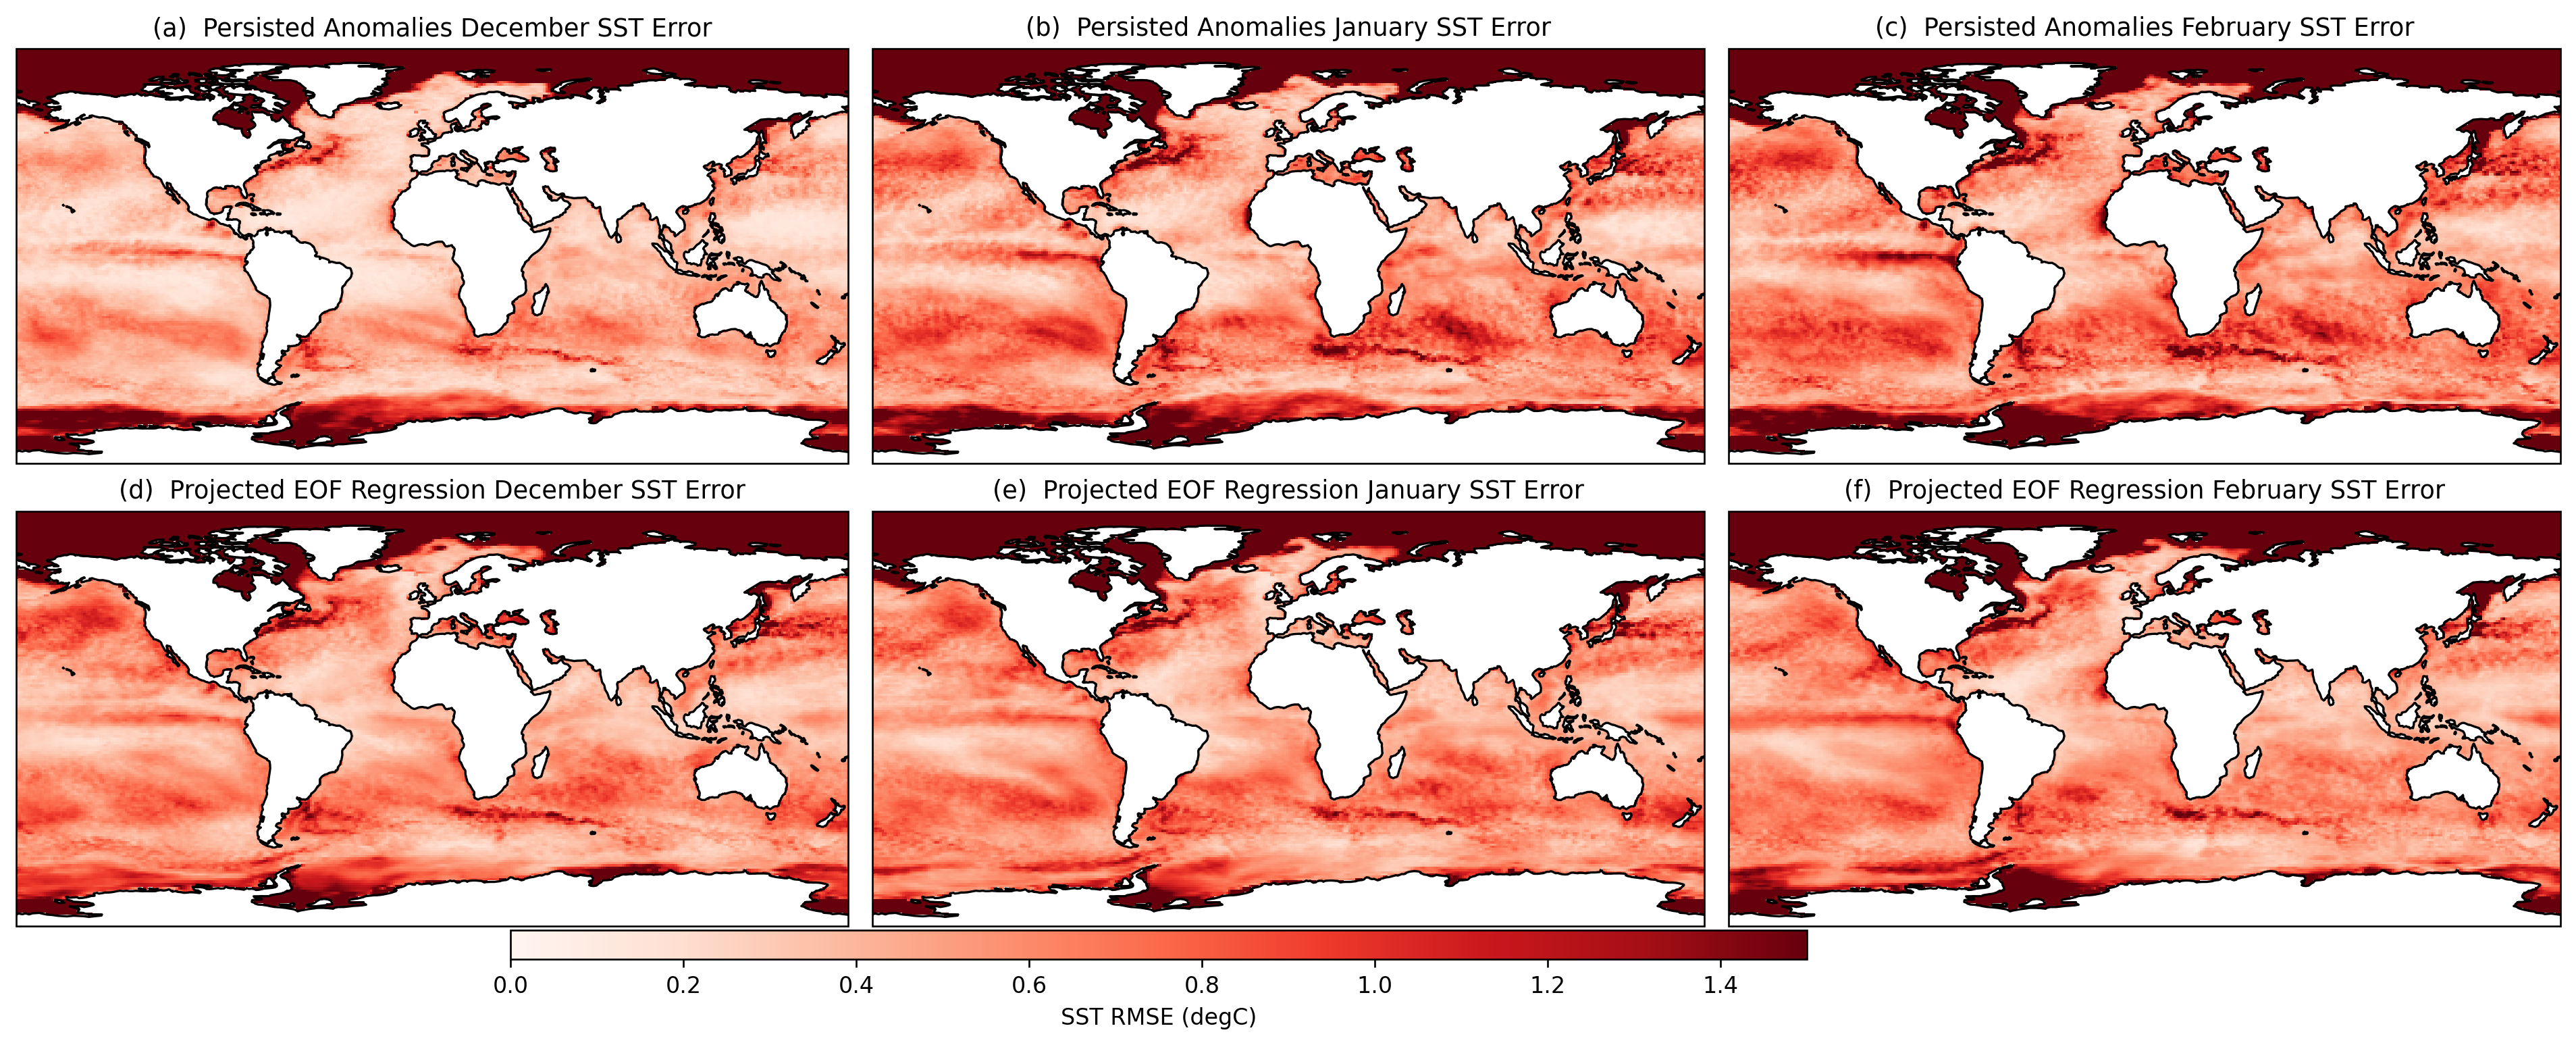

In [48]:

def plotting_monthly_error(row1, row2, vmin, vmax, cmap, cbar_label):

    months = ["December", "January", "February"]
    
    # ---------------------------------------------
    # Plotting: 2 rows × 3 cols
    # ---------------------------------------------
    fig, axes = plt.subplots(
        nrows=2, ncols=3, 
        figsize=(16, 6),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    
    letter_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
    
    
    # Row 1 ----------------------------------------------------
    for i in range(3):
        ax = axes[0, i]
        plot_da = row1[i]
    
        im = ax.pcolormesh(
            plot_da.lon, plot_da.lat, 
            plot_da,
            transform=ccrs.PlateCarree(),
            shading='auto',
            cmap=cmap,
            vmin=vmin, vmax=vmax
        )
        ax.coastlines()
        ax.set_title(f"{letter_labels[i]}  Persisted Anomalies {months[i]} SST Error", fontsize=11)
    
    # Row 2 ----------------------------------------------------
    for i in range(3):
        ax = axes[1, i]
        plot_da = row2[i]
    
        im = ax.pcolormesh(
            plot_da.lon, plot_da.lat, 
            plot_da,
            transform=ccrs.PlateCarree(),
            shading='auto',
            cmap=cmap,
            vmin=vmin, vmax=vmax
        )
        ax.coastlines()
        ax.set_title(f"{letter_labels[i+3]}  Projected EOF Regression {months[i]} SST Error", fontsize=11)
    
    # Colorbar
    cax = fig.add_axes([0.2, 0.01, 0.5, 0.03])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
    cbar.set_label(cbar_label)
    
    plt.tight_layout()
    plt.show()

row1 = [dec_p, jan_p, feb_p]
row2 = [dec_e, jan_e, feb_e]
plotting_monthly_error(row1, row2, 0, 1.5, 'Reds', "SST RMSE (degC)")

/tmp/ipykernel_3575049/2465861257.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


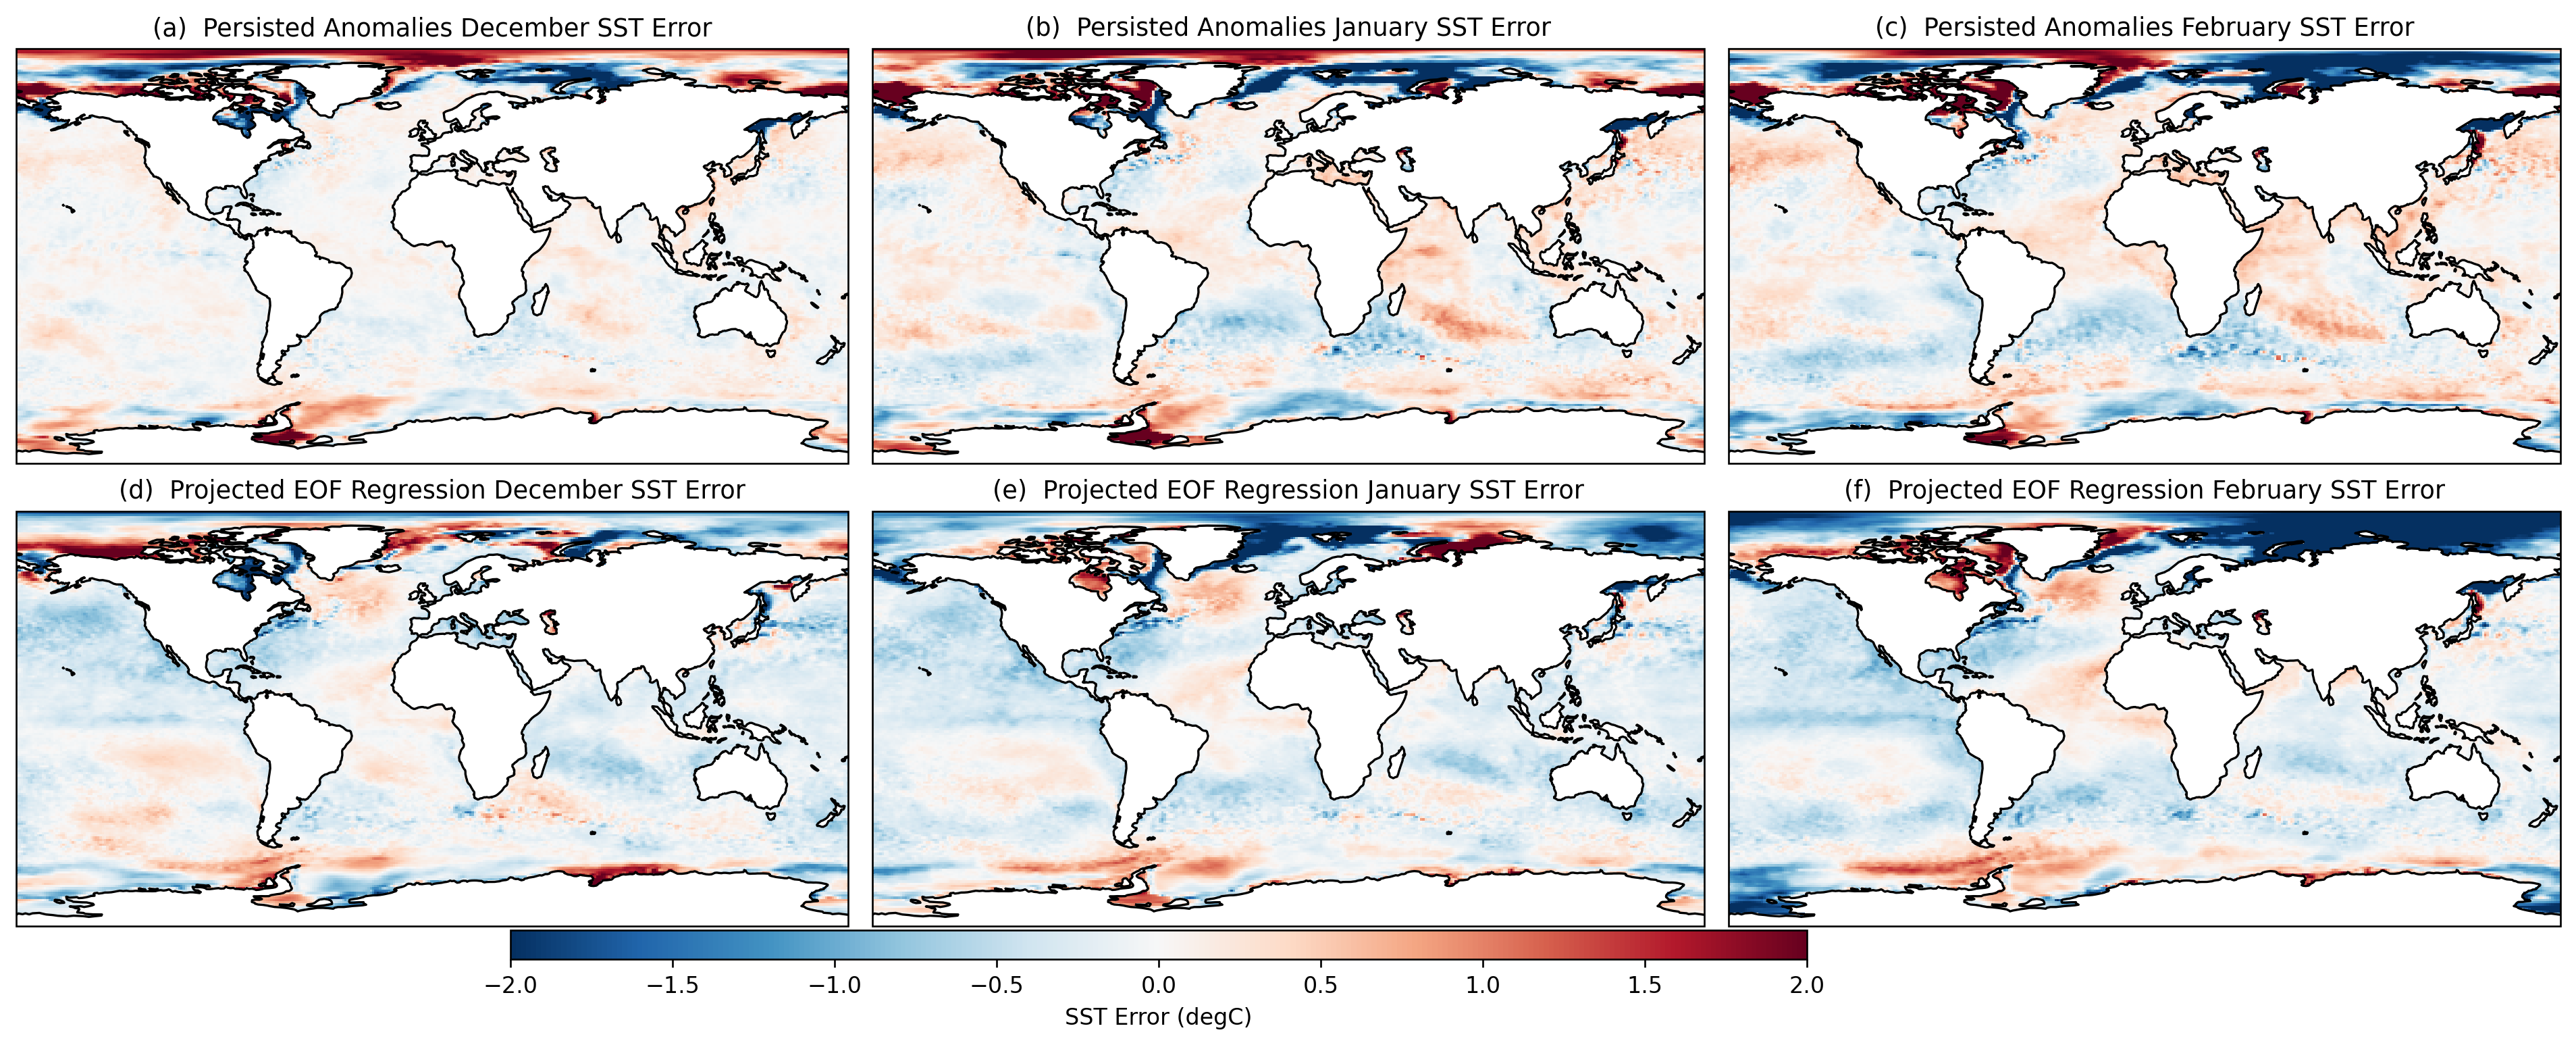

In [49]:
row1 = [dec_p_error, jan_p_error, feb_p_error]
row2 = [dec_e_error, jan_e_error, feb_e_error]
plotting_monthly_error(row1, row2, -2, 2, 'RdBu_r', "SST Error (degC)")


### Daily RMSE

In [50]:
rmse_daily_persist = np.sqrt((error_masked_persist**2).mean(dim=["lat", "lon"])).load()
rmse_daily_eof = np.sqrt((error_masked**2).mean(dim=["lat", "lon"])).load()

In [52]:
rmse_p_doy = rmse_daily_persist.groupby("time.dayofyear").mean("time")
rmse_e_doy = rmse_daily_eof.groupby("time.dayofyear").mean("time")


### Daily RMSE plot

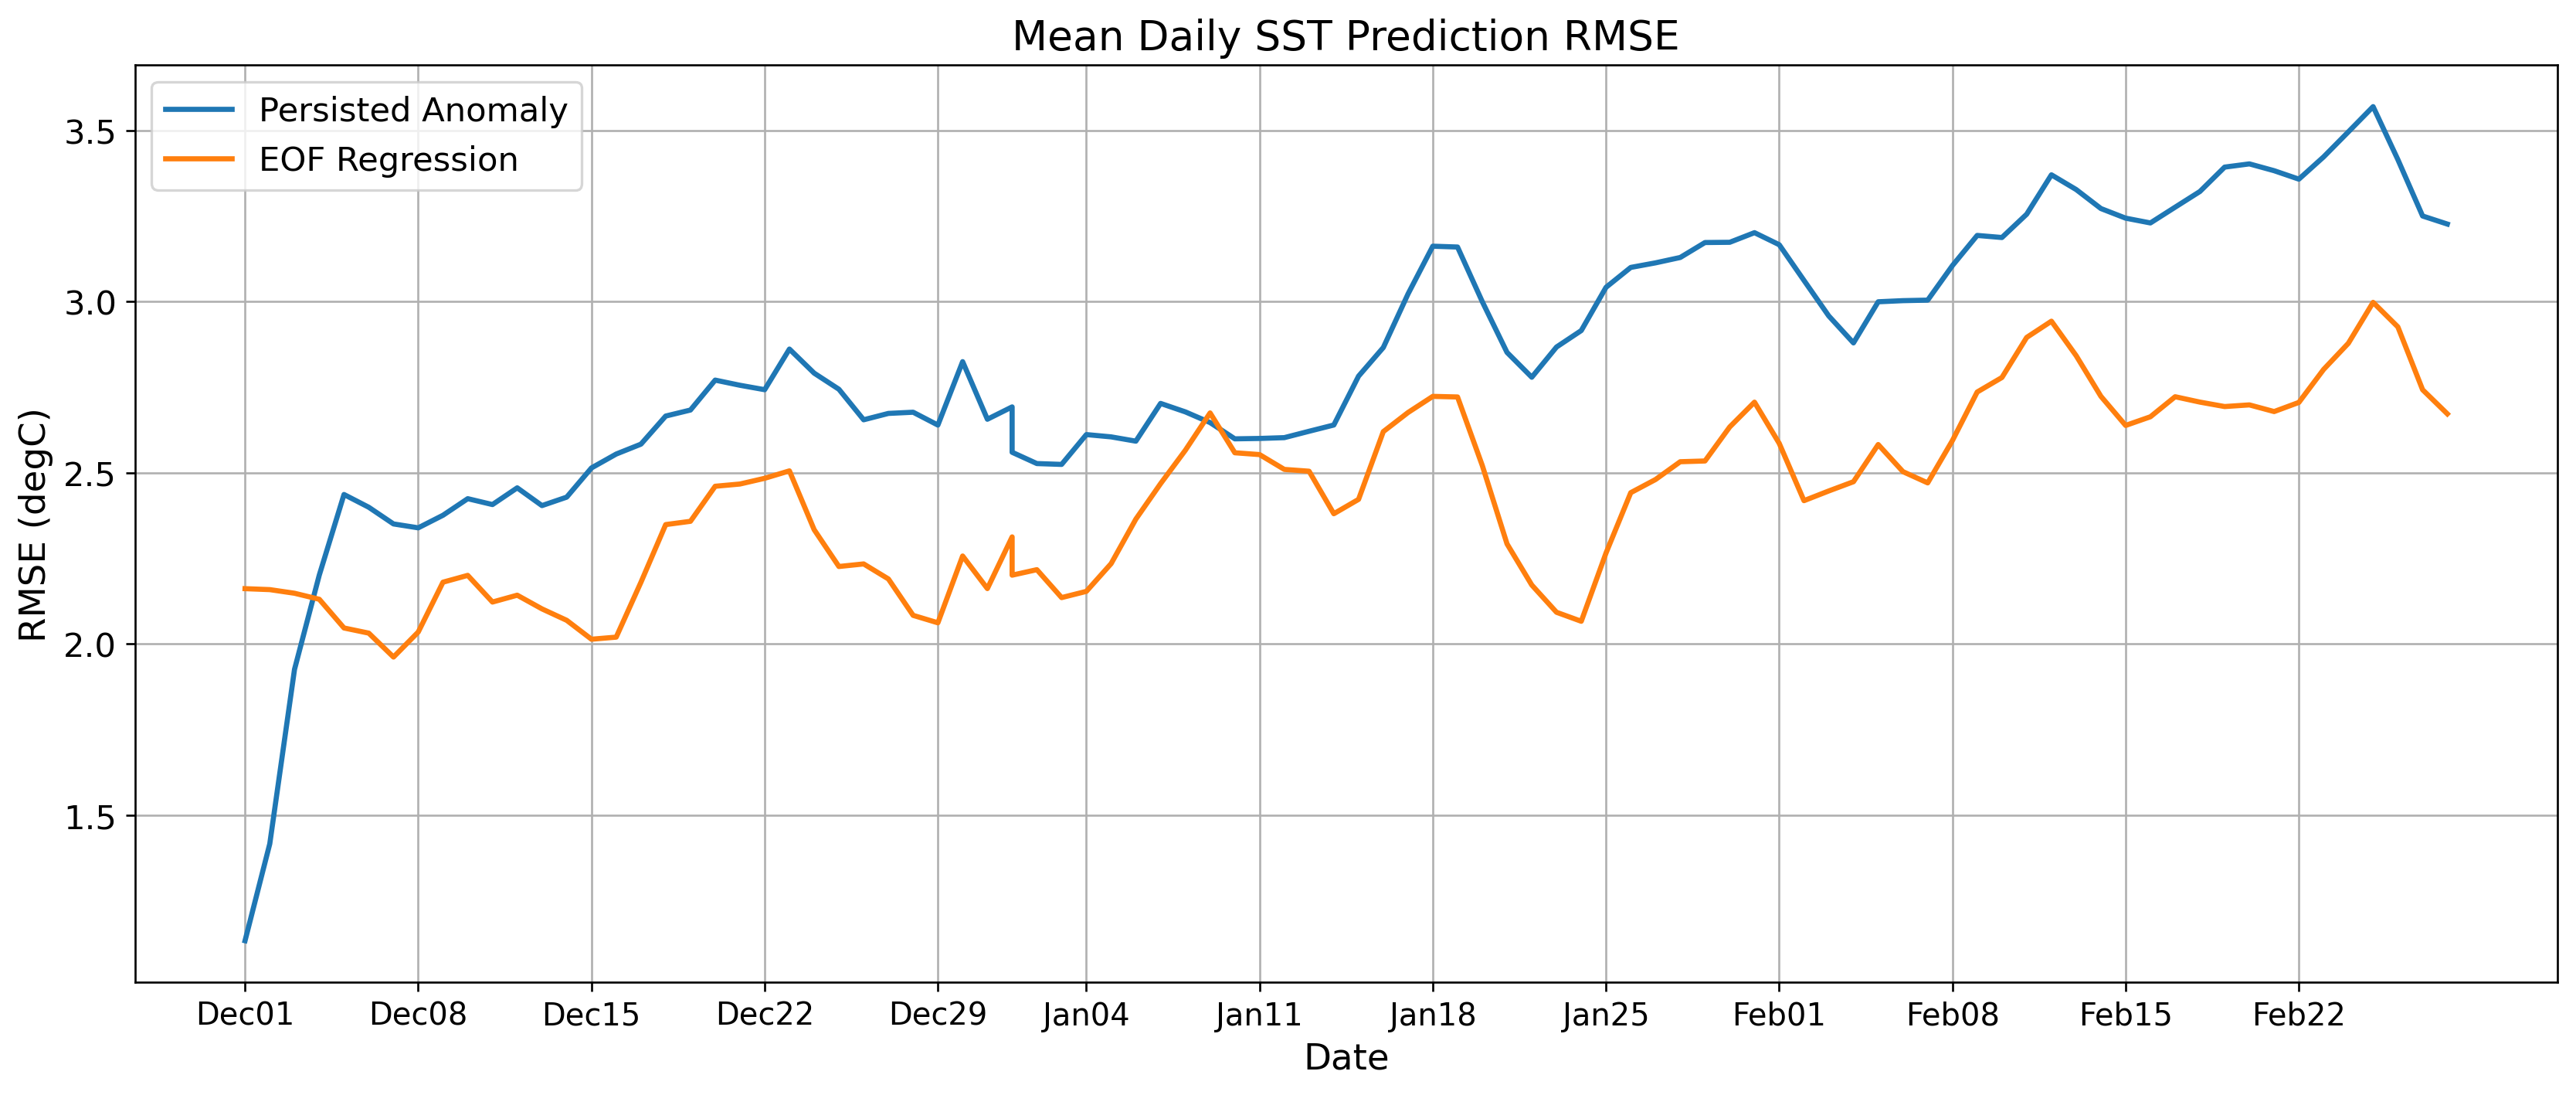

In [53]:

# --- DJF date axis (length matches your 91-day arrays) ---
dec_days = 366 - 335 + 1  # 32 days
jan_feb_days = 59          # 1–59 → 59 days

dec_dates = pd.date_range("2000-12-01", periods=dec_days)
jan_feb_dates = pd.date_range("2001-01-01", periods=jan_feb_days)
djf_dates = dec_dates.append(jan_feb_dates)  # 32 + 59 = 91

# --- Reorder RMSE arrays to chronological order ---
dec_idx = rmse_p_doy.dayofyear >= 335
janfeb_idx = rmse_p_doy.dayofyear <= 59

rmse_p_chrono = xr.concat([rmse_p_doy[dec_idx], rmse_p_doy[janfeb_idx]], dim="dayofyear")
rmse_e_chrono = xr.concat([rmse_e_doy[dec_idx], rmse_e_doy[janfeb_idx]], dim="dayofyear")

# --- Assign the DJF date axis ---
rmse_p_chrono = rmse_p_chrono.assign_coords(dayofyear=djf_dates)
rmse_e_chrono = rmse_e_chrono.assign_coords(dayofyear=djf_dates)

# --- Convert xarray coordinate to pandas DatetimeIndex for plotting ---
dates = pd.to_datetime(rmse_p_chrono.dayofyear.values)

# --- Plot ---
plt.figure(figsize=(14,6))
plt.plot(dates, rmse_p_chrono.values, label="Persisted Anomaly", linewidth=2)
plt.plot(dates, rmse_e_chrono.values, label="EOF Regression", linewidth=2)

# X-axis formatting: month+day only, every 7th tick to avoid crowding
plt.xticks(
    ticks=dates[::7],
    labels=[d.strftime("%b%d") for d in dates[::7]],
    fontsize=12
)
plt.yticks(fontsize=13)
plt.xlabel("Date", fontsize=14)
plt.ylabel("RMSE (degC)", fontsize=14)
plt.title("Mean Daily SST Prediction RMSE", fontsize=16)
plt.legend(fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()
